Notebook created on 25/06/2025 to investigate EUl small domain MAR3.14-MPI sim

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

veg_mar = ['No Veg.', # 0
           'Crops Low', # 1
           'Crops Medium', # 2
           'Crops High', # 3
           'Grass low', # 4
           'Grass Medium', # 5
           'Grass High', # 6
           'Broadleaf Low', # 7
           'Broadleaf Medium', # 8
           'Broadleaf High', # 9
           'Needle Low', # 10
           'Needle Medium', # 11
           'Needle High', # 12
           'City'] # 13

In [3]:
ds_small = xr.open_dataset('/bettik/castelli/MARout/EUh/h01/2015/ICE.h01.2015.01.01-31.nc')[["LON","LAT","SH","FRV","VEG"]]
#ds_smallish = xr.open_dataset('/bettik/castelli/MARout/EUm/m01/2014/ICE.m01.2014.09.01-30.nc')[["LON","LAT","SH","FRV","VEG"]]
ds_smallish = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/v3.14/MARgrid_EUm.nc')
ds_big = xr.open_dataset('/bettik/castelli/MARout/EUn/n01/2014/ICE.n01.2014.09.01-30.nc')[["LON","LAT","SH","FRV","VEG"]]

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

alps_month = np.repeat(alps[np.newaxis,:,:],12,axis=0)

lon_smallish = np.array(ds_smallish.LON)
lat_smallish = np.array(ds_smallish.LAT)
H_smallish = np.array(ds_smallish.SH)
alps_smallish = detect_alps(H_smallish)
alps_smallish[lon_smallish<4.8] = False
alps_smallish[np.logical_and(lon_smallish>10,lat_smallish<45.2)] = False

In [5]:
def open_monthly_data_ave(vars,year,month,days_in_month,sim,timestep_in_hours = 2,imin = 32,imax = -30,jmin = 20,jmax = -15,whichpath='castelli',
                         ds_sect = ds_small,combine=False):
    # average of mosaics
    # example of vars : ["GF","SWU","SWD","HAcc","LWU","LWD","SHF","LHF","HA_col","MBm","MBr","MBmTop","MBrTop","MB","MBrr","SAbs_v","SAbs","CC","CU","CM","CD",
    #                    "QQz","TTz","ST","SWt"]
    if whichpath=='castelli':
        path = '/bettik/castelli/MARout/EU'
    else:
        path = '/bettik/menegozm/MARout/EU'
    letter = sim[0]
    code = sim[1:]
    path = path+letter+'/'+letter+code+'/'+year+'/ICE.'+letter+code+'.'+year+'.'

    #ds_day = xr.open_dataset(path+letter+'/'+letter+code+'/'+year+'/ICE.'+letter+code+'.'+year+'.'+month+'.01-'+days_in_month+'.nc')[vars].isel(x=slice(imin,imax),
    #                                                                                                                                                y=slice(jmin,jmax))
    if combine:
        files = []
        for i in range(len(month)):
            files.append(path+month[i]+'.01-'+days_in_month[i]+'.nc')
        ds_day = xr.open_mfdataset(files,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')[vars].isel(x=slice(imin,imax),
                                                                                                                                                y=slice(jmin,jmax))
    else:
        ds_day = xr.open_dataset(path+month+'.01-'+days_in_month+'.nc')[vars].isel(x=slice(imin,imax),y=slice(jmin,jmax))
        
    # Melt
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*timestep_in_hours # 60*60*24 seconds in a day
    if('MBm' in vars):
        melt_MBm = ds_day.MBm.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBm.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBm.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100 # in mm = L.m**(-2) = kg.m**(-2) because for liquid water 1L=1kg
        ds_day_melt = melt_MBm * Lf / t_timestep # kg.m**(-2) * J.kg**(-1) / s = J/s.m**(-2) = W.m**(-2)
        ds_day['melt'] = -ds_day_melt # minus sign because energy is LOST by surface in order to melt snow
    if('MBr' in vars):
        freez_MBr = ds_day.MBr.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBr.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MBr.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez = freez_MBr * Lf / t_timestep
        ds_day['freeze'] = ds_day_freez
    if('MBmTop' in vars):
        melt_MBm_top = ds_day.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_melt_top = melt_MBm_top * Lf / t_timestep
        ds_day['melt_top'] = -ds_day_melt_top
    if('MBrTop' in vars):
        freez_MBr_top = ds_day.MBrTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBrTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBrTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez_top = freez_MBr_top * Lf / t_timestep
        ds_day['freeze_top'] = ds_day_freez_top
    if('MB' in vars):
        average_snow = ds_day.MB.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MB.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MB.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day['MBave'] = average_snow
    if('SWD' in vars and 'SWU' in vars):
        ds_day['NSW'] = ds_day.SWD - ds_day.SWU
    if('LWD' in vars and 'LWU' in vars):
        ds_day['NLW'] = ds_day.LWD - ds_day.LWU
    if('TTz' in vars):
        ds_day['TT2'] = ds_day.TTz.sel(ztqlev=2.0)
    if('SWt' in vars):
        ds_day['SWt'] = -ds_day['SWt'] # - sign because the energy transmitted to lower layers is LOST by the surface
    if('MBrr' in vars and 'MBsf' in vars):
        ds_day['precip'] = ds_day.MBrr + ds_day.MBsf
    if('SWD' in vars and 'SWU' in vars and 'LWD' in vars and 'LWU' in vars and 'SHF' in vars and 'LHF' in vars and 'MBmTop' in vars and 'MBrTop' in vars and 'GF' in vars
       and 'HAcc' in vars and 'SWt' in vars):
        ds_day_surf_balance = ds_day.NSW + ds_day.NLW + ds_day.SHF + ds_day.LHF + ds_day.melt_top + ds_day.freeze_top + ds_day.GF + ds_day.HAcc + ds_day.SWt
        ds_day['Surf_Bal'] = ds_day_surf_balance

    return ds_day

In [6]:
def plot_comparison(list_ds,months,min,max,colormap,label_var,suptitle_var,ds_size=ds_small,N=11,cols=5,rows=2):

    f, axs = pplt.subplots(proj='cyl',axwidth=2,ncols=cols,nrows=rows,axheight=1.)

    for mon in range(cols*rows):    
        ax=axs[mon]
        m = ax.pcolormesh(ds_size.LON,ds_size.LAT,list_ds[mon],levels=np.linspace(min,max,N),cmap=colormap)
        ax.format(title=months[mon])

    f.colorbar(m,label= label_var,labelsize='large',ticklabelsize='large')
    axs.format(**multiplot_format,suptitle=suptitle_var)

In [7]:
def open_nc_monthly(scenario,first_year,last_year,ds_sect):
    inipath = '/bettik/castelli/data/MAR-MPI-ESM/v3.14/'+scenario+'/ICE.MPI_ESM_'+scenario+'.EUm.' # initial path

    for year in range(first_year,last_year):
        ds_monthly = xr.open_dataset(inipath+list_var[0]+'.'+str(year)+'.nc').resample(time='M').mean()

        for var in list_vars[1:]:
            ds_monthly[var] = xr.open_dataset(inipath+var+'.'+str(year)+'.nc').resample(time='M').mean()

    # Melt
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*24*complete # 60*60*24 seconds in a day
    if('MBm' in vars):
        melt_MBm = ds_monthly.MBm.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_monthly.MBm.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_monthly.MBm.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100 # in mm = L.m**(-2) = kg.m**(-2) because for liquid water 1L=1kg
        ds_monthly_melt = melt_MBm * Lf / t_timestep # kg.m**(-2) * J.kg**(-1) / s = J/s.m**(-2) = W.m**(-2)
        ds_monthly['melt'] = -ds_monthly_melt # minus sign because energy is LOST by surface in order to melt snow
    if('MBr' in vars):
        freez_MBr = ds_day.MBr.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBr.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MBr.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez = freez_MBr * Lf / t_timestep
        ds_day['freeze'] = ds_day_freez
    if('MBmTop' in vars):
        melt_MBm_top = ds_day.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_melt_top = melt_MBm_top * Lf / t_timestep
        ds_day['melt_top'] = -ds_day_melt_top
    if('MBrTop' in vars):
        freez_MBr_top = ds_day.MBrTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MBrTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
                   ds_day.MBrTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day_freez_top = freez_MBr_top * Lf / t_timestep
        ds_day['freeze_top'] = ds_day_freez_top
    if('MB' in vars):
        average_snow = ds_day.MB.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_day.MB.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
               ds_day.MB.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
        ds_day['MBave'] = average_snow
    if('SWD' in vars and 'SWU' in vars):
        ds_day['NSW'] = ds_day.SWD - ds_day.SWU
    if('LWD' in vars and 'LWU' in vars):
        ds_day['NLW'] = ds_day.LWD - ds_day.LWU
    if('TTz' in vars):
        ds_day['TT2'] = ds_day.TTz.sel(ztqlev=2.0)
    if('SWt' in vars):
        ds_day['SWt'] = -ds_day['SWt'] # - sign because the energy transmitted to lower layers is LOST by the surface
    if('MBrr' in vars and 'MBsf' in vars):
        ds_day['precip'] = ds_day.MBrr + ds_day.MBsf
    if('SWD' in vars and 'SWU' in vars and 'LWD' in vars and 'LWU' in vars and 'SHF' in vars and 'LHF' in vars and 'MBmTop' in vars and 'MBrTop' in vars and 'GF' in vars
       and 'HAcc' in vars and 'SWt' in vars):
        ds_day_surf_balance = ds_day.NSW + ds_day.NLW + ds_day.SHF + ds_day.LHF + ds_day.melt_top + ds_day.freeze_top + ds_day.GF + ds_day.HAcc + ds_day.SWt
        ds_day['Surf_Bal'] = ds_day_surf_balance

In [8]:
def plot_E_balance_and_T(slopes_var=None,trend=True,year=None,first_year=None,last_year=None,showlegend=True,snowlines=False):
    pplt.rc.update(small=14, large=12)

    n_levels=len(levels)
    n_seas=4
    seasons=['DJF','MAM','JJA','SON']
    colors = ['b','g','r','c','y','m','purple','lightblue','orange','k']
    leg_labels_null = ['','','','','','','','','','']
    leg_labels_full = ['Tmean','Tmin','Tmax','STmean','NSW','NLW','LHF','SHF','Melt','NSW+NLW+LHF+SHF+Melt']
    leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]


    with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
        f, axs = pplt.subplots(ncols=4,axwidth=3)
    axs2 = axs.twiny()
    
    mean_slope_T=np.full((n_seas,n_levels),np.nan)
    mean_slope_Tmin=np.full((n_seas,n_levels),np.nan)
    mean_slope_Tmax=np.full((n_seas,n_levels),np.nan)
    mean_slope_ST=np.full((n_seas,n_levels),np.nan)
    mean_slope_NSW=np.full((n_seas,n_levels),np.nan)
    mean_slope_NLW=np.full((n_seas,n_levels),np.nan)
    mean_slope_LHF=np.full((n_seas,n_levels),np.nan)
    mean_slope_SHF=np.full((n_seas,n_levels),np.nan)
    mean_slope_MBm=np.full((n_seas,n_levels),np.nan)
    mean_slope_energy_balance=np.full((n_seas,n_levels),np.nan)
    mean_slopes = [mean_slope_T,mean_slope_Tmin,mean_slope_Tmax,mean_slope_ST,mean_slope_NSW,mean_slope_NLW,mean_slope_LHF,mean_slope_SHF,mean_slope_MBm,
                   mean_slope_energy_balance]

    std_slope_T=np.full((n_seas,n_levels),np.nan)
    std_slope_Tmin=np.full((n_seas,n_levels),np.nan)
    std_slope_Tmax=np.full((n_seas,n_levels),np.nan)
    std_slope_ST=np.full((n_seas,n_levels),np.nan)
    std_slope_NSW=np.full((n_seas,n_levels),np.nan)
    std_slope_NLW=np.full((n_seas,n_levels),np.nan)
    std_slope_LHF=np.full((n_seas,n_levels),np.nan)
    std_slope_SHF=np.full((n_seas,n_levels),np.nan)
    std_slope_MBm=np.full((n_seas,n_levels),np.nan)
    std_slope_energy_balance=np.full((n_seas,n_levels),np.nan)
    std_slopes = [std_slope_T,std_slope_Tmin,std_slope_Tmax,std_slope_ST,std_slope_NSW,std_slope_NLW,std_slope_LHF,std_slope_SHF,std_slope_MBm,
                  std_slope_energy_balance]

    wp_meanseason_vars = [wp_meanseason_meanT,wp_meanseason_minT,wp_meanseason_maxT,wp_meanseason_ST,wp_meanseason_meanNSW,wp_meanseason_NLW,wp_meanseason_LHF,
                          wp_meanseason_SHF,wp_meanseason_meltflux,wp_meanseason_energy_balance]
    
    for i in range(n_seas): # seasons
        ax = axs[i]
        ax2 = axs2[i]
        
        for j in range(n_levels): # levels
            for var in range(len(wp_meanseason_vars)):
                if trend:
                    slope_var = np.ma.masked_array(slopes_var[var][i], mask=np.invert(levels[j])).reshape(12649)
                    multiplier = 10 # trends per decade so we x10
                elif first_year != None: # not a trend, but averaging over first_year:last_year
                    slope_var = np.ma.masked_array(wp_meanseason_vars[var][first_year:last_year,i].mean(axis=0), mask=np.invert(levels[j])).reshape(12649)
                    multiplier = 1
                else: # taking one year in particular
                    slope_var = np.ma.masked_array(wp_meanseason_vars[var][year-1961,i], mask=np.invert(levels[j])).reshape(12649)
                    multiplier = 1
                
                mean_slopes[var][i,j] = multiplier*slope_var.mean()
                std_slopes[var][i,j] = multiplier*slope_var.std()
                if var<4:
                    ax.plot([multiplier*slope_var.mean()-multiplier*slope_var.std(),multiplier*slope_var.mean()+multiplier*slope_var.std()],[H_levels[j],H_levels[j]],c=colors[var])
                else:
                    ax2.plot([multiplier*slope_var.mean()-multiplier*slope_var.std(),multiplier*slope_var.mean()+multiplier*slope_var.std()],[H_levels[j],H_levels[j]],c=colors[var])


        ax.plot(mean_slope_T[i,:],H_levels,c='b',linestyle='--',label=leg_labels[i][0])
        ax.plot(mean_slope_Tmin[i,:],H_levels,c='g',linestyle='--',label=leg_labels[i][1])
        ax.plot(mean_slope_Tmax[i,:],H_levels,c='r',linestyle='--',label=leg_labels[i][2])
        ax.plot(mean_slope_ST[i,:],H_levels,c='c',linestyle='--',label=leg_labels[i][3])

        if trend:
            ax.set_xlim(-0.5,1.3)
            ax.text(1., 75, seasons[i], fontsize=13,fontweight='semibold')
        else:
            ax.set_xlim(-55.,35)
            ax.text(20, 75, seasons[i], fontsize=13,fontweight='semibold')

        ax.set_ylim(0,3400)
        
        if snowlines:
            #ax.hlines(mean1_snowline_seas[0][0,first_year:last_year,i].mean(),-55,35,c='deepskyblue',linestyle='--')
            #ax.hlines(mean1_snowline_seas[1][0,first_year:last_year,i].mean(),-55,35,c='deepskyblue',linestyle='--')
            #ax.hlines(mean1_snowline_seas[2][0,first_year:last_year,i].mean(),-55,35,c='deepskyblue',linestyle='--')
            ax.hlines(mean10_snowline_seas[0][0,first_year:last_year,i].mean(),-55,35,c='deepskyblue')
            ax.hlines(mean10_snowline_seas[1][0,first_year:last_year,i].mean(),-55,35,c='deepskyblue')
            ax.hlines(mean10_snowline_seas[2][0,first_year:last_year,i].mean(),-55,35,c='deepskyblue')
        
        ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
        ax2.plot(mean_slope_NSW[i,:],H_levels,c='y',label=leg_labels[i][4])
        ax2.plot(mean_slope_NLW[i,:],H_levels,c='m',label=leg_labels[i][5])
        ax2.plot(mean_slope_LHF[i,:],H_levels,c='purple',label=leg_labels[i][6])
        ax2.plot(mean_slope_SHF[i,:],H_levels,c='lightblue',label=leg_labels[i][7])
        ax2.plot(mean_slope_MBm[i,:],H_levels,c='orange',label=leg_labels[i][8])
        ax2.plot(mean_slope_energy_balance[i,:],H_levels,c='k',label=leg_labels[i][9])
        #ax2.plot(mean_slope_NSW[i,:]+mean_slope_NLW[i,:]+mean_slope_LHF[i,:]+mean_slope_SHF[i,:],H_levels,c='k',linestyle='--')

        if trend:
            ax2.set_xlim(-6,15)
        else:
            ax2.set_xlim(-90,320)
        

    if showlegend:
        f.legend(loc='b',prop = { "size": 14 },ncols=4)
    
    if trend:
        xLabel = 'T trend (°C/decade)'
        Suptitle='Surface energy flux trend (W/$m^2$/dec)'
    else:
        xLabel = 'T (°C)'
        Suptitle='Surface energy flux (W/$m^2$)'

    if year != None:
        axs[0].text(x=10,y=3000,s=f'Year = {year}')
    axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle)


In [9]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [10]:
# function for seasonal mean (from Ian)
def season_mean2(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).resample(time='QS-DEC').sum()

### Comparison v3.14 vs v3.10, MAR-MPI SSP585, 7km resolution on big domain for both

In [11]:
# MARv3.10
name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'SSP585'
sim = 'EUy'
sim2 = 'EUy'
data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly
year = 2015

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUy2015 = xr.open_dataset(ssp585_path)


ds_EUy2015['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUy2015["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUy2015["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUy2015["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUy2015["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUy2015["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
ds_EUy2015["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUy2015["precip"] = ds_EUy2015["MBrr"] + ds_EUy2015["MBsf"]

In [67]:
# MARv3.10
name_GCM = 'ERA5'
code_GCM = 'ERA5_v1'
#scenario = 'SSP585'
sim = 'EUl'
sim2 = 'EUl'
data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly
year = 2015

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUl2015 = xr.open_dataset(ssp585_path)


ds_EUl2015['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUl2015["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUl2015["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUl2015["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUl2015["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUl2015["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
#ds_EUl2015["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'.'+sim2+ \
#                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUl2015["precip"] = ds_EUl2015["MBrr"] + ds_EUl2015["MBsf"]

In [71]:
vars_list = ["SWU","SWD","CC","QQz","TTz","ST"]
ds_EUn012015 = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04','05','06','07','08','09','10','11'],
                                     days_in_month=['31','28','31','30','31','30','31','31','30','31','30'],sim='n01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True, ds_sect = ds).resample(time='D').mean()

vars_list = ["MBrr","MBsf"]
ds_EUn012015_precip = open_monthly_data_ave(vars=vars_list,year='2015',month=['01','02','03','04','05','06','07','08','09','10','11'],
                                     days_in_month=['31','28','31','30','31','30','31','31','30','31','30'],sim='n01',timestep_in_hours = 4,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True, ds_sect = ds).resample(time='D').sum()

In [13]:
ds_EUy2015 = ds_EUy2015.assign_coords(x=ds_EUn012015.x)
ds_EUy2015 = ds_EUy2015.assign_coords(y=ds_EUn012015.y).isel(y=slice(jmin,jmax),x=slice(imin,imax))

In [72]:
ds_EUl2015 = ds_EUl2015.assign_coords(x=ds_EUn012015.x)
ds_EUl2015 = ds_EUl2015.assign_coords(y=ds_EUn012015.y).isel(y=slice(jmin,jmax),x=slice(imin,imax))

In [87]:
ds_EUn012015 = ds_EUn012015.isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_EUn012015_precip = ds_EUn012015_precip.isel(y=slice(jmin,jmax),x=slice(imin,imax))

In [15]:
ds_EUy2015

<xarray.Dataset>
Dimensions:  (time: 365, ztqlev: 4, y: 91, x: 139, plev: 7)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-31T12:00:00
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
  * y        (y) float32 -168.0 -161.0 -154.0 -147.0 ... 441.0 448.0 455.0 462.0
  * ztqlev   (ztqlev) float32 2.0 10.0 50.0 100.0
  * plev     (plev) float32 925.0 850.0 800.0 700.0 600.0 500.0 200.0
Data variables:
    TTz      (time, ztqlev, y, x) float32 ...
    CC       (time, y, x) float32 ...
    MBrr     (time, y, x) float32 ...
    MBsf     (time, y, x) float32 ...
    SWD      (time, y, x) float32 ...
    QQz      (time, ztqlev, y, x) float32 ...
    ST       (time, y, x) float32 ...
    TTp      (time, plev, y, x) float32 ...
    precip   (time, y, x) float32 2.169e-05 8.876e-05 ... 0.3987 0.3008
Attributes:
    title:        ICE - Exp: y56 - 20150101
    institution:  ULg (Xavier Fettweis)
    history:      Fri Jan 29 23:53:18 2021: ncks -v TTz ICE.y56.2015.01.01-31...
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          4.0.9

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

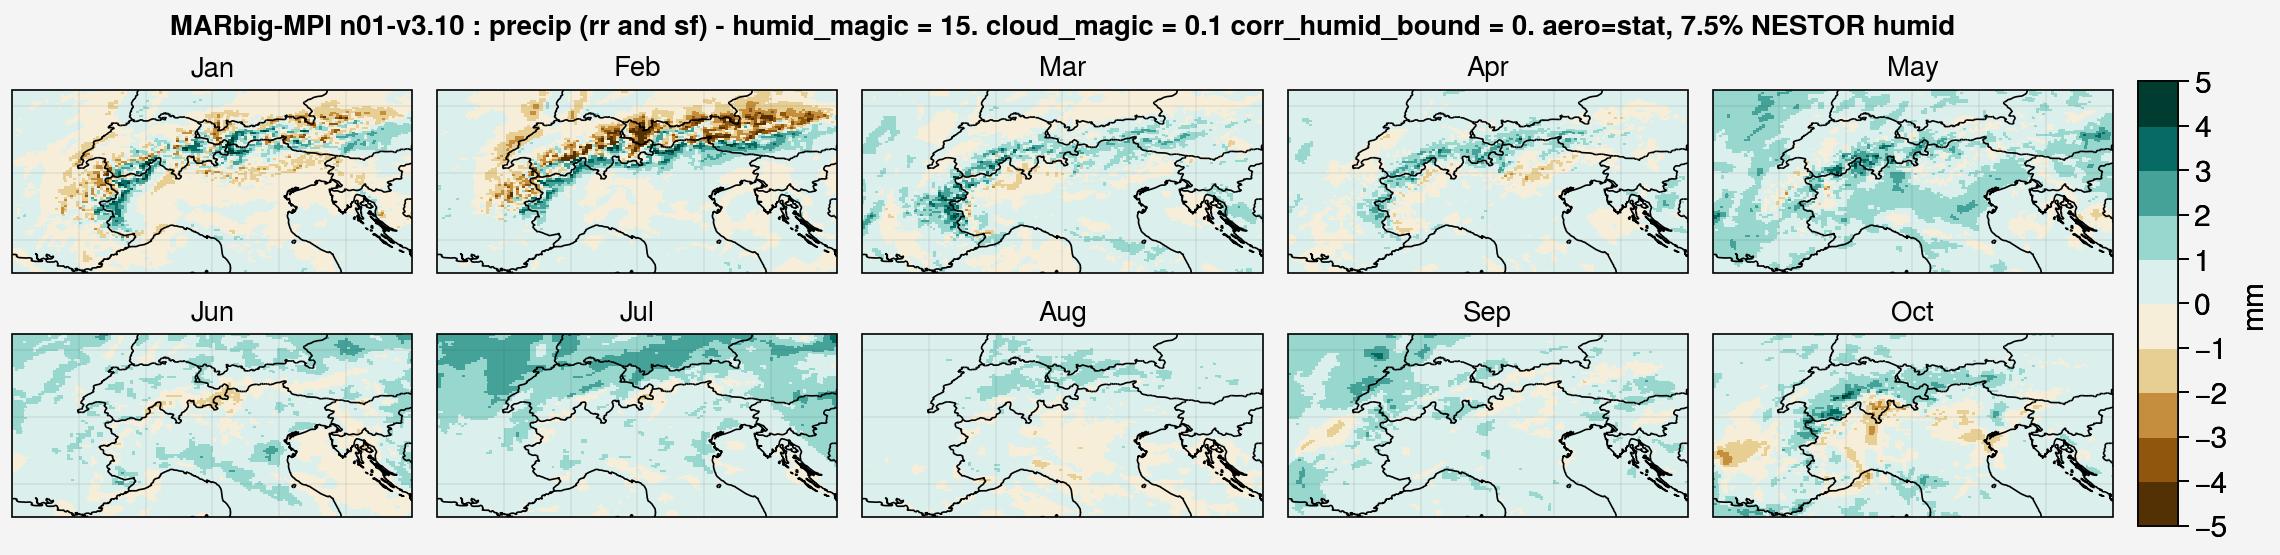

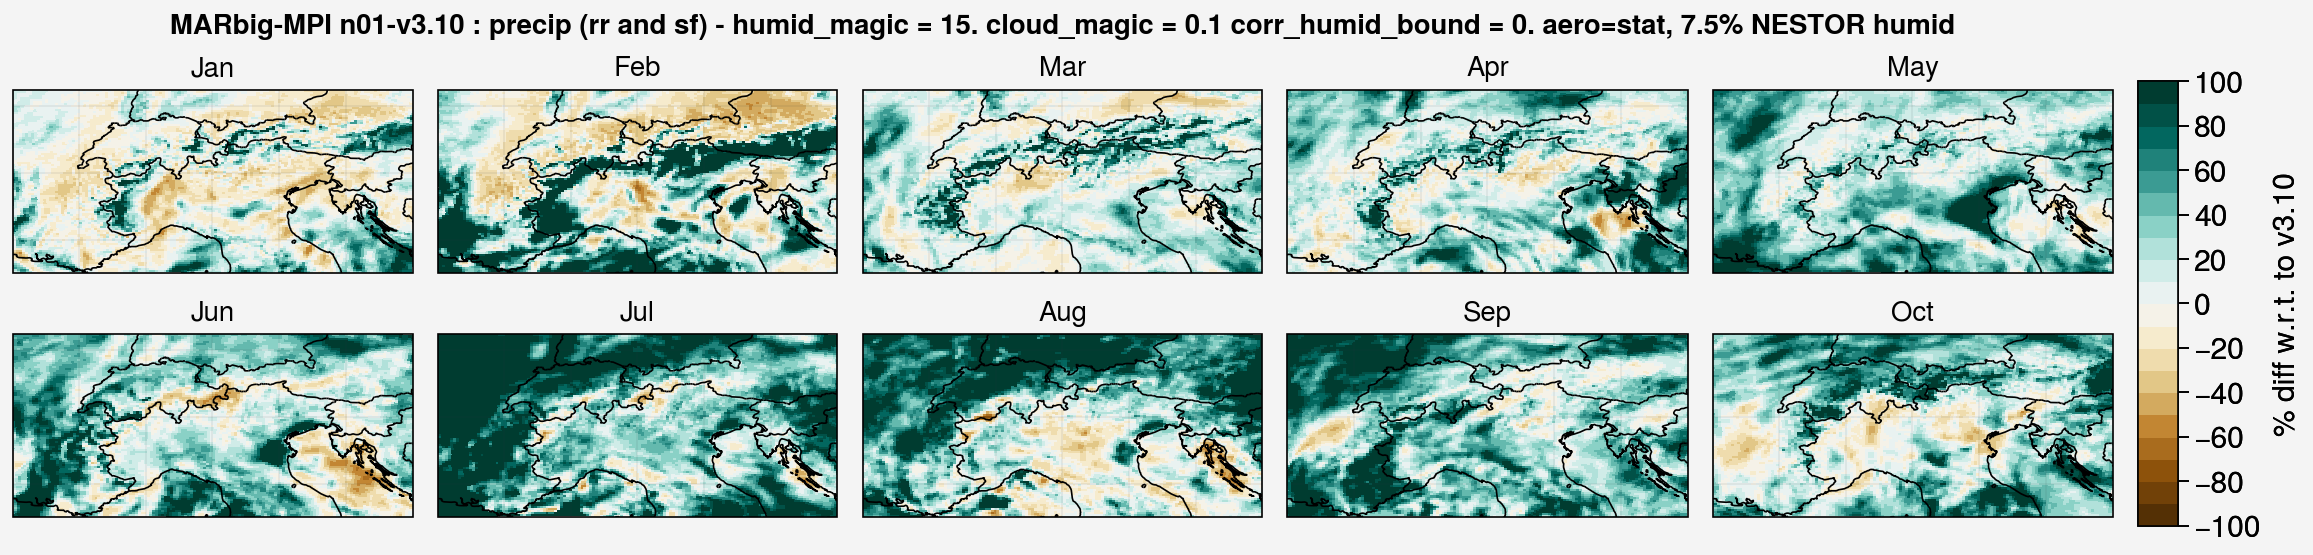

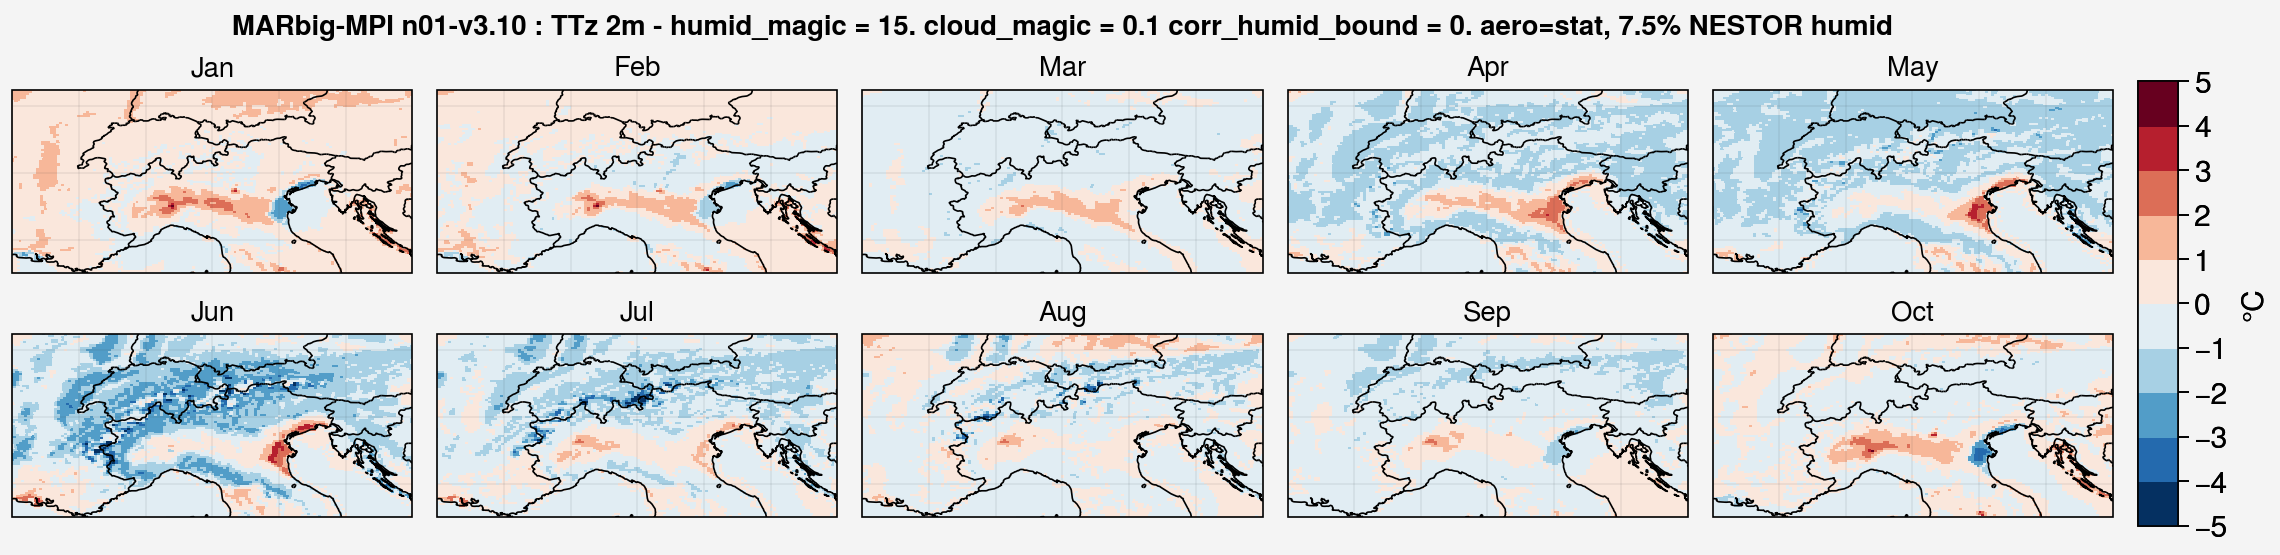

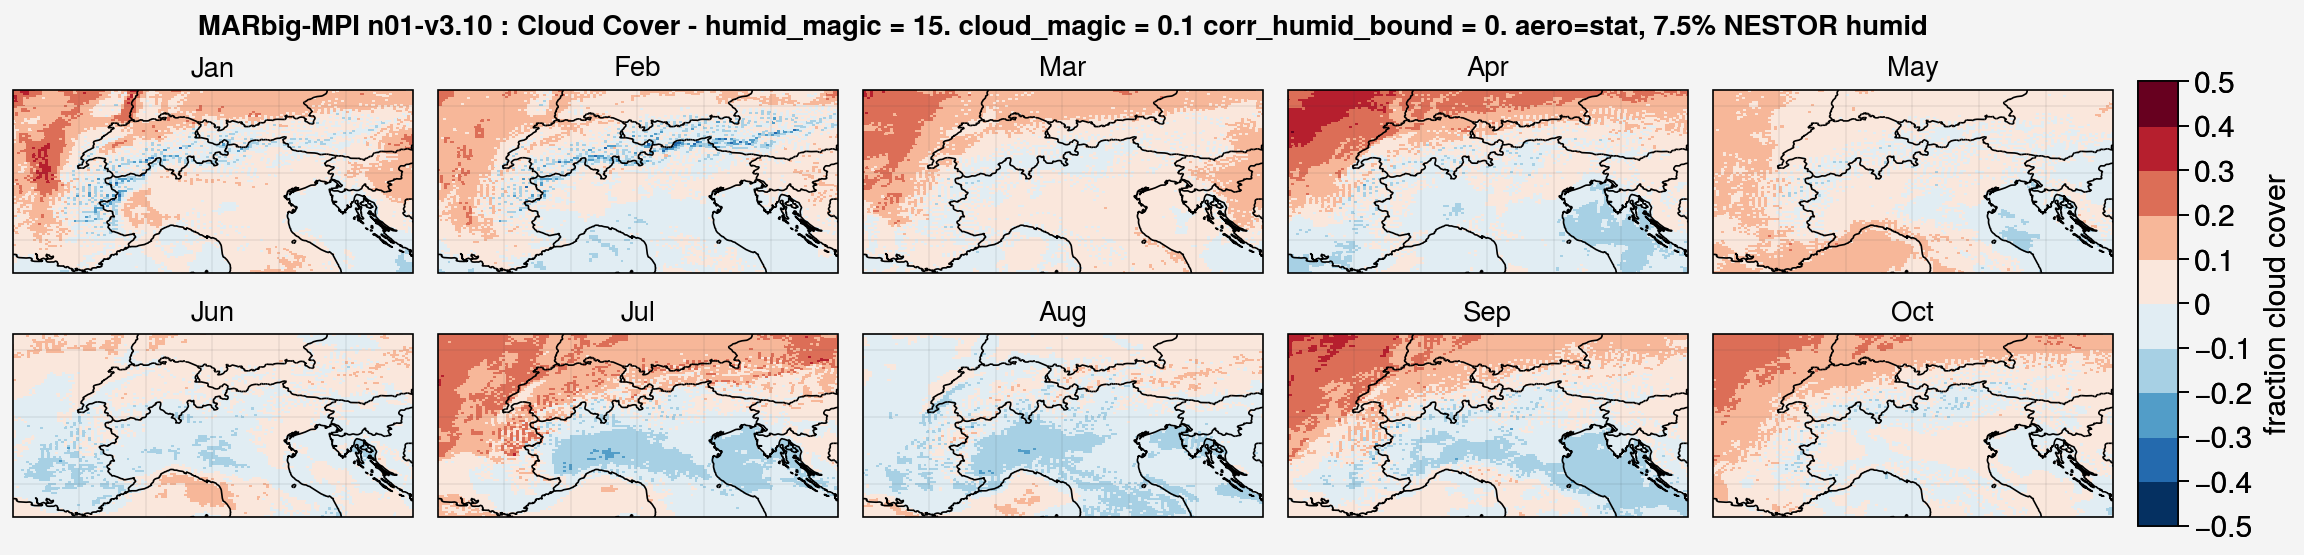

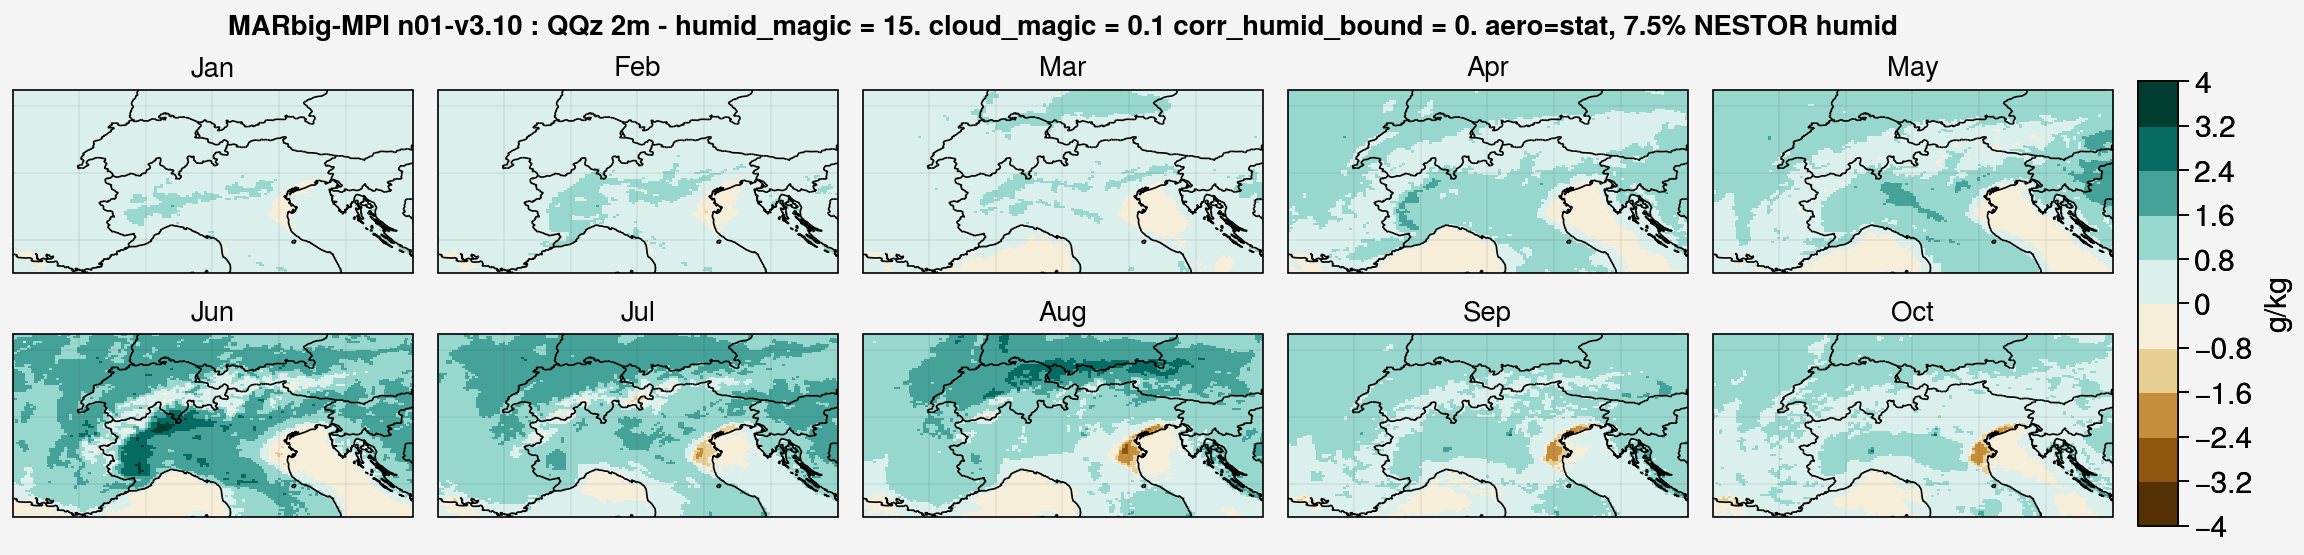

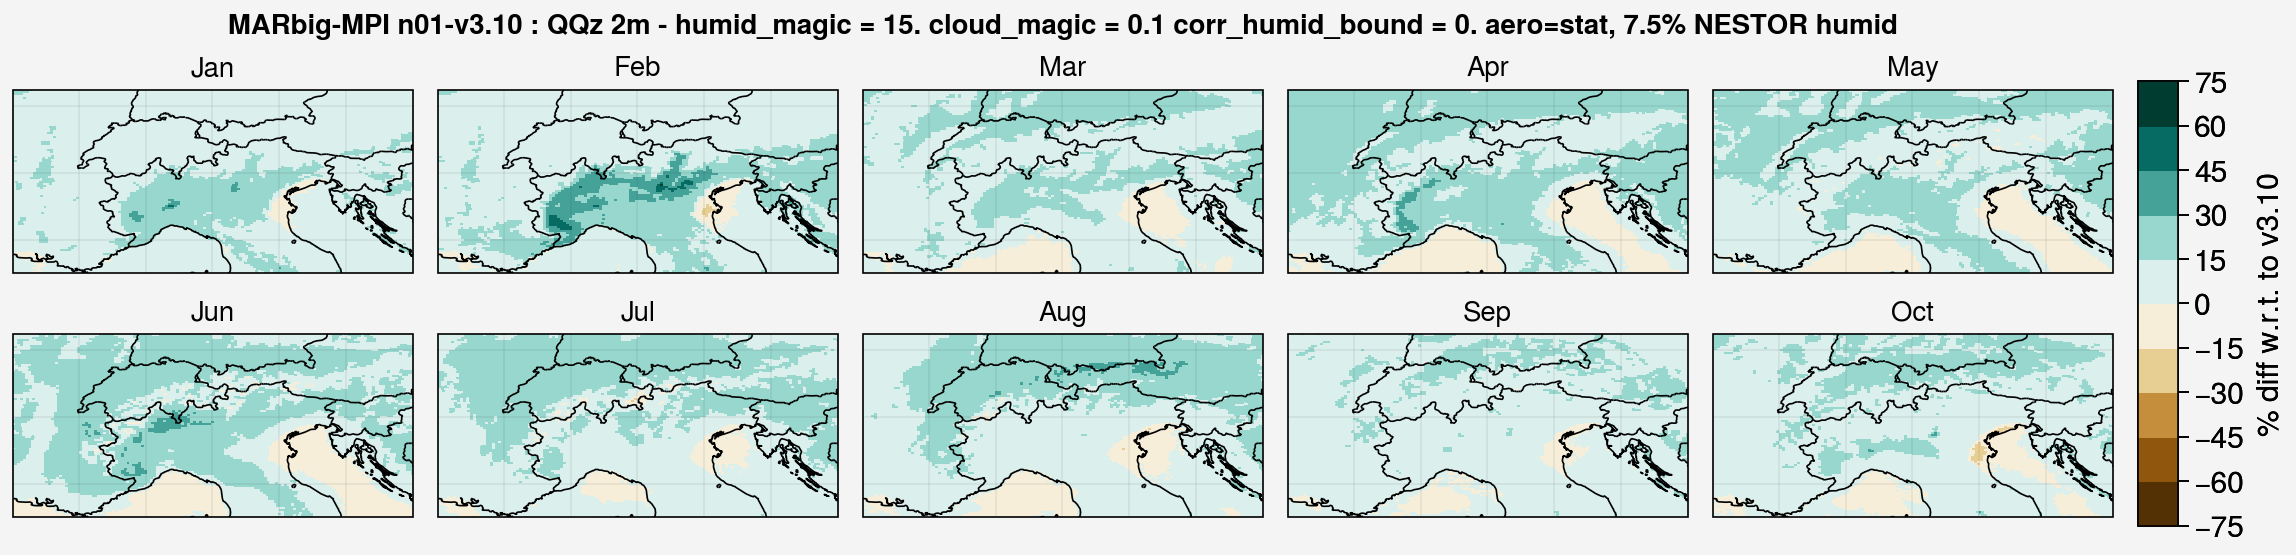

In [25]:
#n01
plot_comparison(list_ds = ds_EUn012015_precip.precip.groupby("time.month").mean() - ds_EUy2015.precip.groupby("time.month").mean()[:11],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],min = -5,max = 5,N=11,colormap = 'BrBG',label_var = 'mm',
                suptitle_var = 'MARbig-MPI n01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=2,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = 100*(ds_EUn012015_precip.precip.groupby("time.month").mean() - ds_EUy2015.precip.groupby("time.month").mean()[:11])/ \
                ds_EUy2015.precip.groupby("time.month").mean()[:11],months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],min = -100,max = 100,N=21,
                colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARbig-MPI n01-v3.10 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=2,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))


plot_comparison(list_ds = ds_EUn012015.TTz.sel(ztqlev=2.0).groupby("time.month").mean() - ds_EUy2015.TTz.sel(ztqlev=2.0).groupby("time.month").mean()[:11],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],min = -5,max = 5,N=11,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARbig-MPI n01-v3.10 : TTz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=2,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = ds_EUn012015.CC.groupby("time.month").mean() - ds_EUy2015.CC.groupby("time.month").mean()[:11],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],min = -0.5,max = 0.5,N=11,colormap = 'RdBu_r',label_var = 'fraction cloud cover',
                suptitle_var = 'MARbig-MPI n01-v3.10 : Cloud Cover - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=2,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = ds_EUn012015.QQz.sel(ztqlev=2.0).groupby("time.month").mean() - ds_EUy2015.QQz.sel(ztqlev=2.0).groupby("time.month").mean()[:11],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],min = -4,max = 4,N=11,colormap = 'BrBG',label_var = 'g/kg',
                suptitle_var = 'MARbig-MPI n01-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=2,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = 100*(ds_EUn012015.QQz.sel(ztqlev=2.0).groupby("time.month").mean() - ds_EUy2015.QQz.sel(ztqlev=2.0).groupby("time.month").mean()[:11])/ \
                ds_EUy2015.QQz.sel(ztqlev=2.0).groupby("time.month").mean()[:11],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],min = -75,max = 75,N=11,colormap = 'BrBG',label_var = '% diff w.r.t. to v3.10',
                suptitle_var = 'MARbig-MPI n01-v3.10 : QQz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=2,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

In [92]:
alps28 = np.repeat(alps[np.newaxis,:,:],28,axis=0)
alps30 = np.repeat(alps[np.newaxis,:,:],30,axis=0)
alps31 = np.repeat(alps[np.newaxis,:,:],31,axis=0)

ds_v = ds_EUn012015['QQz'].sel(ztqlev=2.0)

mskJan_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-01-01','2015-01-31')), mask = np.invert(alps31)).flatten()
mskFeb_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-02-01','2015-02-28')), mask = np.invert(alps28)).flatten()
mskMar_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-03-01','2015-03-31')), mask = np.invert(alps31)).flatten()
mskApr_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-04-01','2015-04-30')), mask = np.invert(alps30)).flatten()
mskMay_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-05-01','2015-05-31')), mask = np.invert(alps31)).flatten()
mskJun_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-06-01','2015-06-30')), mask = np.invert(alps30)).flatten()
mskJul_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-07-01','2015-07-31')), mask = np.invert(alps31)).flatten()
mskAug_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-08-01','2015-08-31')), mask = np.invert(alps31)).flatten()
mskSep_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-09-01','2015-09-30')), mask = np.invert(alps30)).flatten()
mskOct_EUn012015 = np.ma.masked_array(ds_v.sel(time=slice('2015-10-01','2015-10-31')), mask = np.invert(alps31)).flatten()

listmsk_EUn012015 = [mskJan_EUn012015, mskFeb_EUn012015, mskMar_EUn012015, mskApr_EUn012015, mskMay_EUn012015, mskJun_EUn012015, mskJul_EUn012015, mskAug_EUn012015,
                     mskSep_EUn012015, mskOct_EUn012015] 

mskJan_EUn012015.mean()

3.0292213801655143

In [93]:
# EUl or EUy depending on if forced by ERA5 or MPI

ds_v = ds_EUy2015['QQz'].sel(ztqlev=2.0)

mskJan_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-01-01','2015-01-31')), mask = np.invert(alps31)).flatten()
mskFeb_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-02-01','2015-02-28')), mask = np.invert(alps28)).flatten()
mskMar_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-03-01','2015-03-31')), mask = np.invert(alps31)).flatten()
mskApr_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-04-01','2015-04-30')), mask = np.invert(alps30)).flatten()
mskMay_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-05-01','2015-05-31')), mask = np.invert(alps31)).flatten()
mskJun_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-06-01','2015-06-30')), mask = np.invert(alps30)).flatten()
mskJul_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-07-01','2015-07-31')), mask = np.invert(alps31)).flatten()
mskAug_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-08-01','2015-08-31')), mask = np.invert(alps31)).flatten()
mskSep_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-09-01','2015-09-30')), mask = np.invert(alps30)).flatten()
mskOct_EUy2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-10-01','2015-10-31')), mask = np.invert(alps31)).flatten()

listmsk_EUy2015 = [mskJan_EUy2015, mskFeb_EUy2015, mskMar_EUy2015, mskApr_EUy2015, mskMay_EUy2015, mskJun_EUy2015, mskJul_EUy2015, mskAug_EUy2015,
                     mskSep_EUy2015, mskOct_EUy2015] 

mskJan_EUy2015.mean()

2.7656861765427276

In [94]:
# EUl or EUy depending on if forced by ERA5 or MPI

ds_v = ds_EUl2015['QQz'].sel(ztqlev=2.0)

mskJan_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-01-01','2015-01-31')), mask = np.invert(alps31)).flatten()
mskFeb_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-02-01','2015-02-28')), mask = np.invert(alps28)).flatten()
mskMar_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-03-01','2015-03-31')), mask = np.invert(alps31)).flatten()
mskApr_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-04-01','2015-04-30')), mask = np.invert(alps30)).flatten()
mskMay_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-05-01','2015-05-31')), mask = np.invert(alps31)).flatten()
mskJun_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-06-01','2015-06-30')), mask = np.invert(alps30)).flatten()
mskJul_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-07-01','2015-07-31')), mask = np.invert(alps31)).flatten()
mskAug_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-08-01','2015-08-31')), mask = np.invert(alps31)).flatten()
mskSep_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-09-01','2015-09-30')), mask = np.invert(alps30)).flatten()
mskOct_EUl2015 = np.ma.masked_array(ds_v.sel(time=slice('2015-10-01','2015-10-31')), mask = np.invert(alps31)).flatten()

listmsk_EUl2015 = [mskJan_EUl2015, mskFeb_EUl2015, mskMar_EUl2015, mskApr_EUl2015, mskMay_EUl2015, mskJun_EUl2015, mskJul_EUl2015, mskAug_EUl2015,
                     mskSep_EUl2015, mskOct_EUl2015] 

mskJan_EUl2015.mean()

3.3706321935665557

In [17]:
Jan_EUn012015 = np.array(ds_EUn012015.CC.sel(time=slice('2015-01-01','2015-01-31'))).flatten()
Jan_EUn012015.mean()

0.7381425

{'whiskers': [<matplotlib.lines.Line2D at 0x148b38db2440>,
 'caps': [<matplotlib.lines.Line2D at 0x148b38c48460>,
 'boxes': [<matplotlib.lines.Line2D at 0x148b38db09d0>,
 'medians': [<matplotlib.lines.Line2D at 0x148b38c49180>,
 'fliers': [<matplotlib.lines.Line2D at 0x148b38c49510>,
 'means': []}

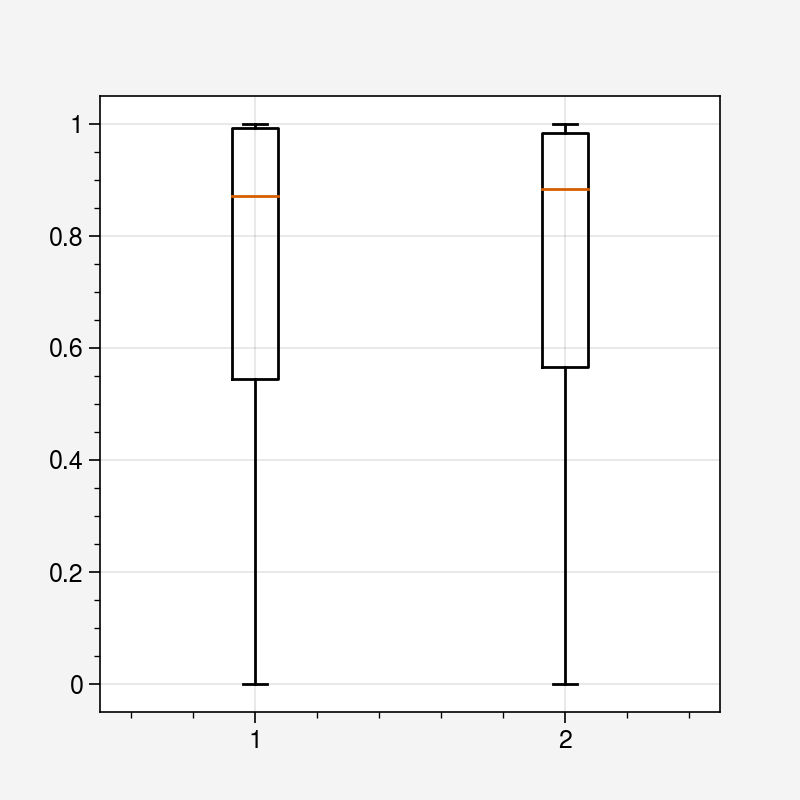

In [20]:
plt.boxplot([mskJan_EUn012015[~mskJan_EUn012015.mask],Jan_EUn012015])

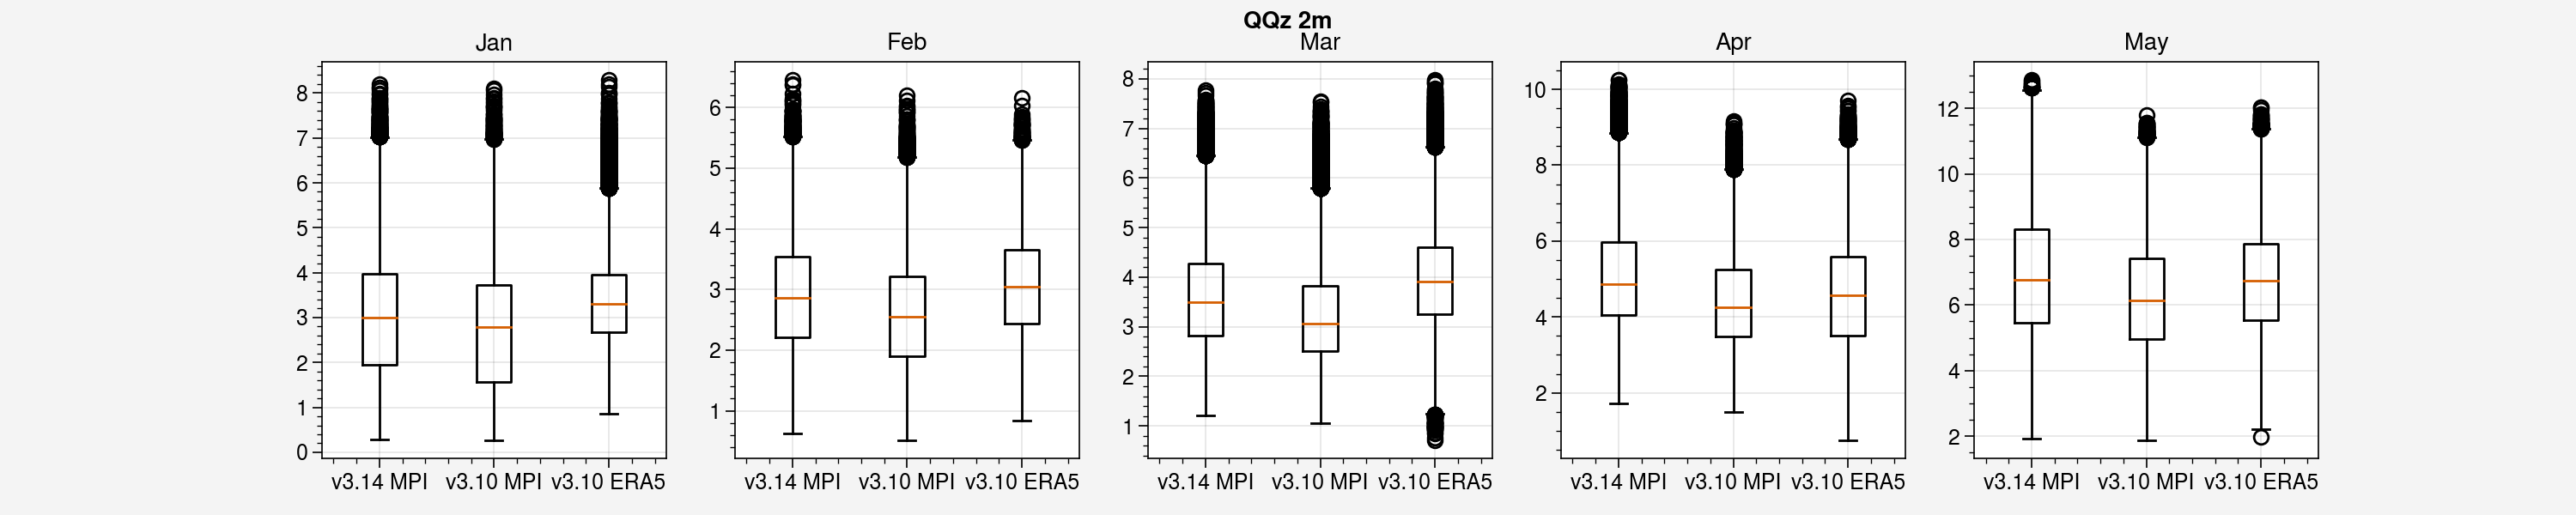

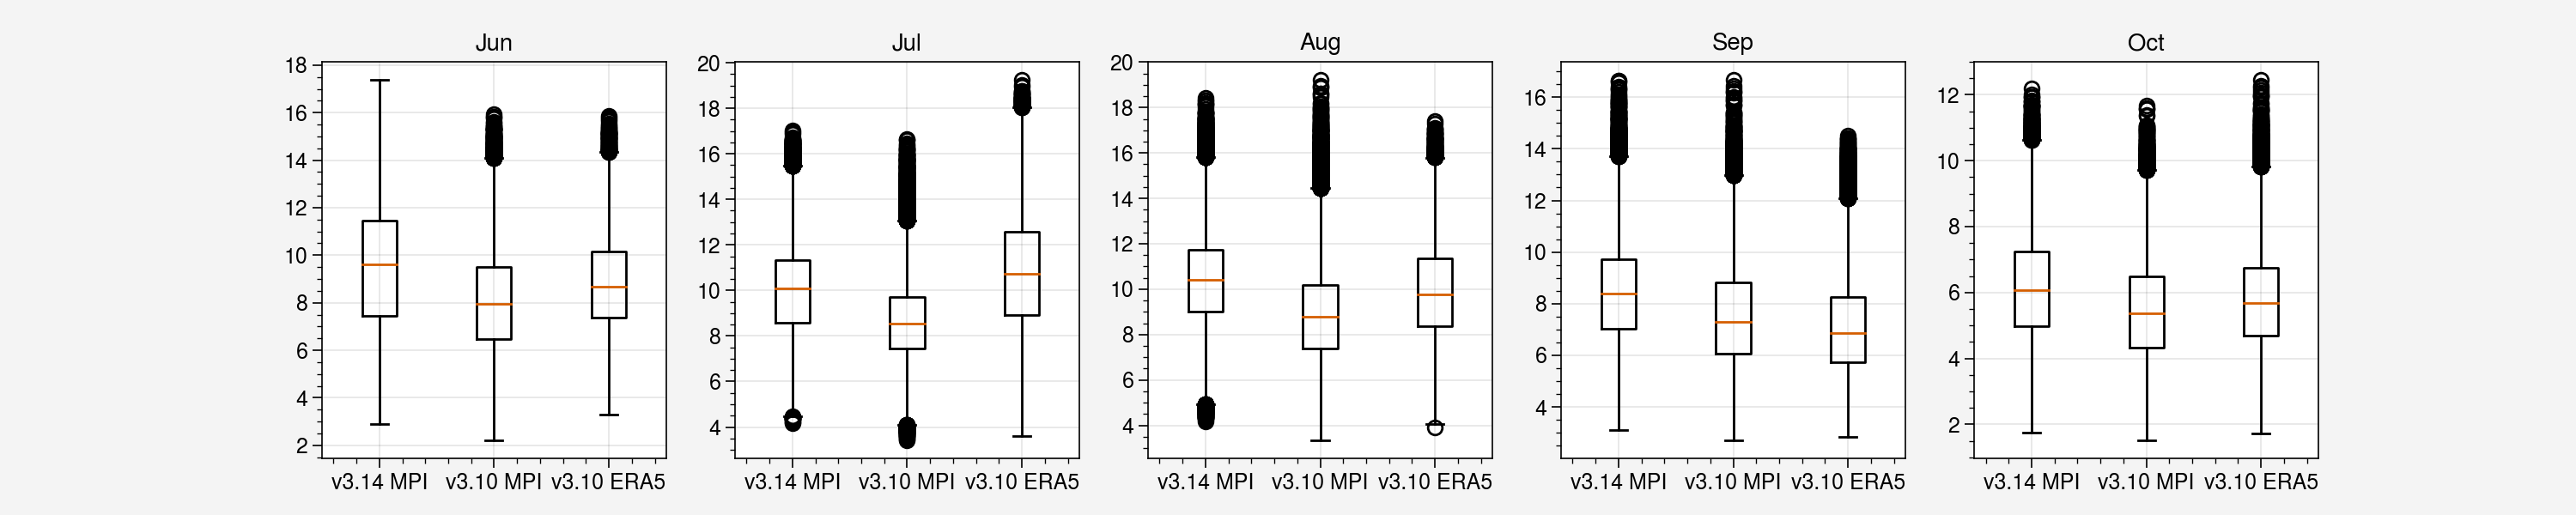

In [95]:
f,axs = plt.subplots(ncols=5)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
#flierprops = dict(marker='o', markerfacecolor='n', markersize=5)

for mon in range(5):
    axs[mon].boxplot([listmsk_EUn012015[mon][~listmsk_EUn012015[mon].mask],listmsk_EUy2015[mon][~listmsk_EUy2015[mon].mask],
                      listmsk_EUl2015[mon][~listmsk_EUl2015[mon].mask]],labels=['v3.14 MPI','v3.10 MPI','v3.10 ERA5'])
    axs[mon].set_title(months[mon])

f.set_figheight(3)
f.set_figwidth(15)
f.suptitle('QQz 2m')

f,axs = plt.subplots(ncols=5)

for mon in range(5):
    axs[mon].boxplot([listmsk_EUn012015[mon+5][~listmsk_EUn012015[mon+5].mask],listmsk_EUy2015[mon+5][~listmsk_EUy2015[mon+5].mask],
                      listmsk_EUl2015[mon+5][~listmsk_EUl2015[mon+5].mask]],labels=['v3.14 MPI','v3.10 MPI','v3.10 ERA5'])
    axs[mon].set_title(months[mon+5])

f.set_figheight(3)
f.set_figwidth(15)


In [ ]:
f,axs=pplt.subplots(ncols = 2)

axs[0].box([mskJan_EUn012015,Jan_EUn012015])
#axs[1].boxplot(np.array(ds_EUn012015.CC.sel(time=slice('2015-01-01','2015-01-31'))).flatten())

### MAR-MPI : EUn n03, MARv3.14

In [29]:
# MARv3.10
name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'HIST'
sim = 'EUy'
sim2 = 'EUy'
data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly
year = 1961

ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.TTz.'+str(year)+'.nc'
ds_EUy1961 = xr.open_dataset(ssp585_path)


ds_EUy1961['CC'] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.CC.'+str(year)+'.nc').CC
ds_EUy1961["MBrr"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBrr.'+str(year)+'.nc').MBrr
ds_EUy1961["MBsf"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MBsf.'+str(year)+'.nc').MBsf
ds_EUy1961["MB"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.MB.'+str(year)+'.nc').MB
ds_EUy1961["SWD"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.SWD.'+str(year)+'.nc').SWD
ds_EUy1961["QQz"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.QQz.'+str(year)+'.nc').QQz
ds_EUy1961["ST"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.ST.'+str(year)+'.nc').ST
ds_EUy1961["TTp"] = xr.open_dataset('/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+ \
                                   '.TTp.'+str(year)+'.nc').TTp

ds_EUy1961["precip"] = ds_EUy1961["MBrr"] + ds_EUy1961["MBsf"]

In [30]:
vars_list = ["SWU","SWD","CC","QQz","TTz","ST","MB","MBrr","MBsf"]
ds_EUn031960 = open_monthly_data_ave(vars=vars_list,year='1960',month=['09','10','11','12'],
                                     days_in_month=['30','31','30','31'],sim='n03',timestep_in_hours = 24,
                                         imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=True, ds_sect = ds)




In [31]:
ds_EUy1961 = ds_EUy1961.assign_coords(x=ds_EUn031960.x)
ds_EUy1961 = ds_EUy1961.assign_coords(y=ds_EUn031960.y).isel(y=slice(jmin,jmax),x=slice(imin,imax))

ds_EUn031960 = ds_EUn031960.isel(y=slice(jmin,jmax),x=slice(imin,imax))

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

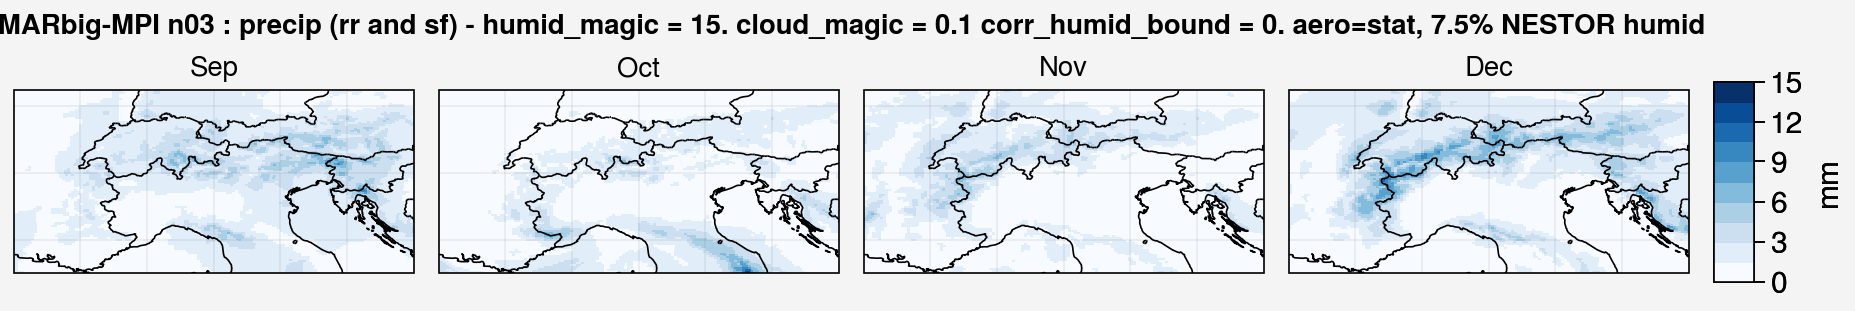

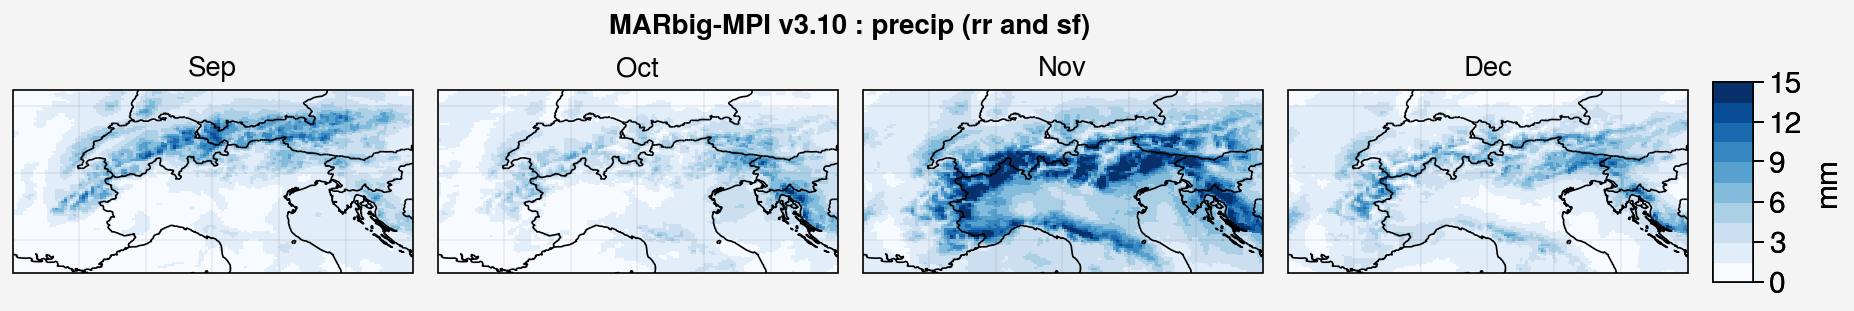

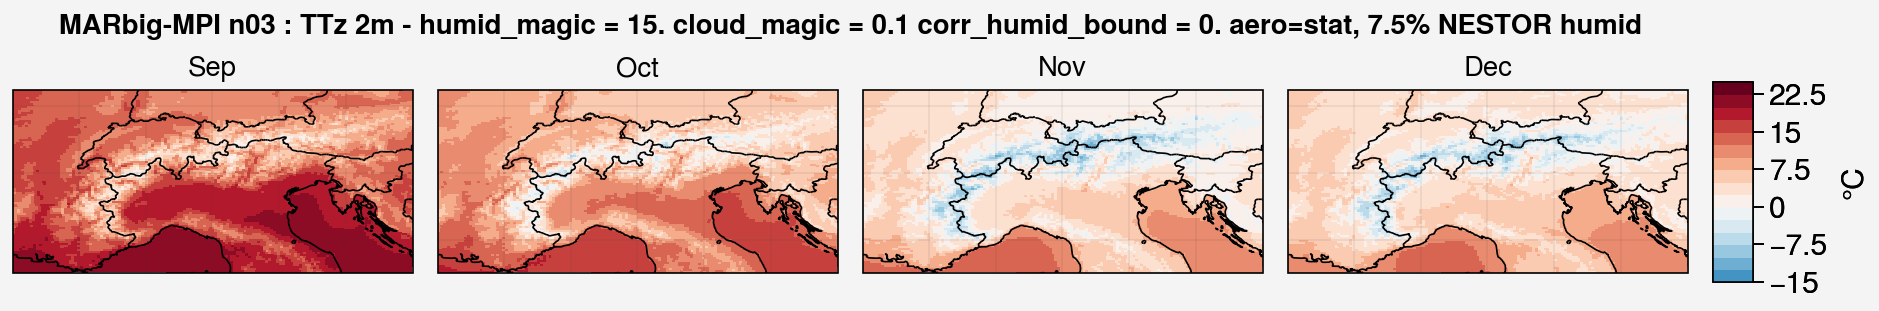

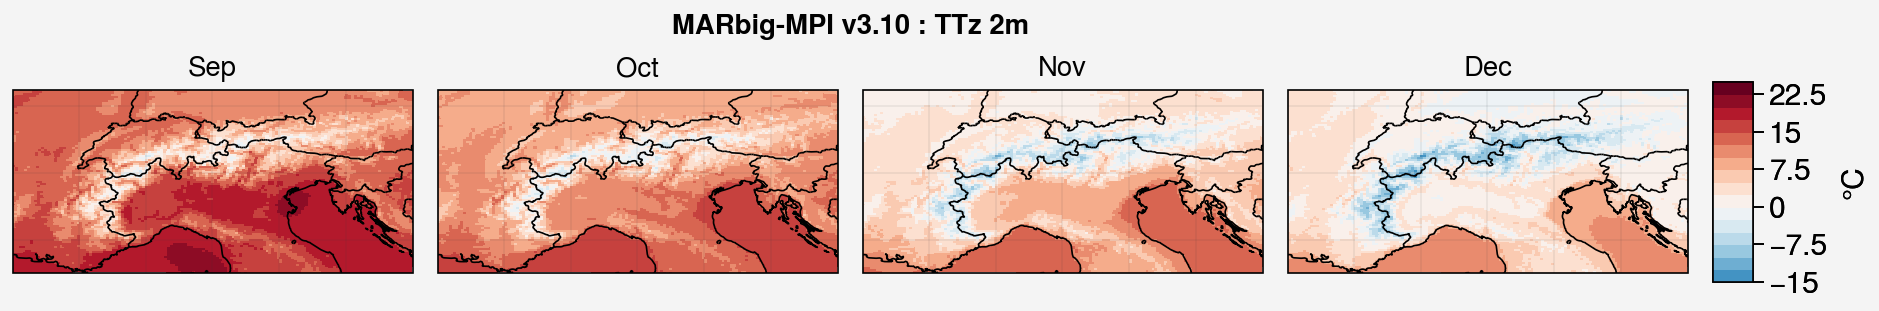

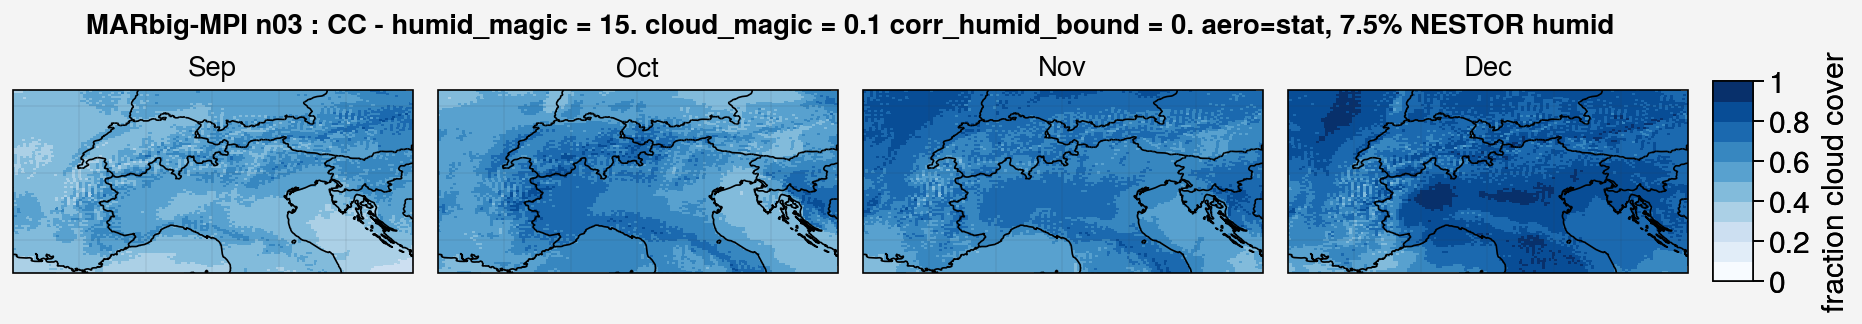

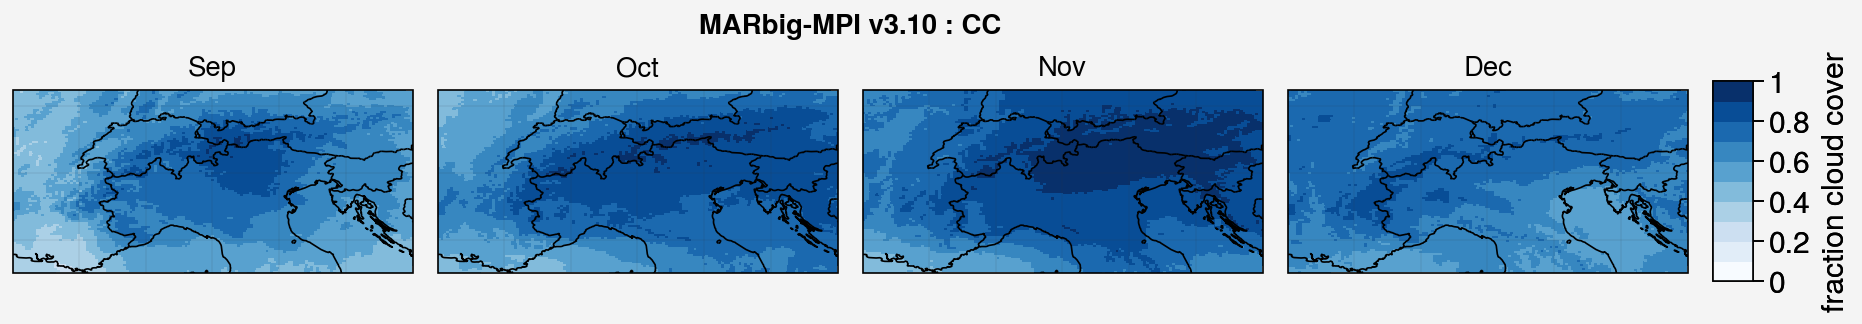

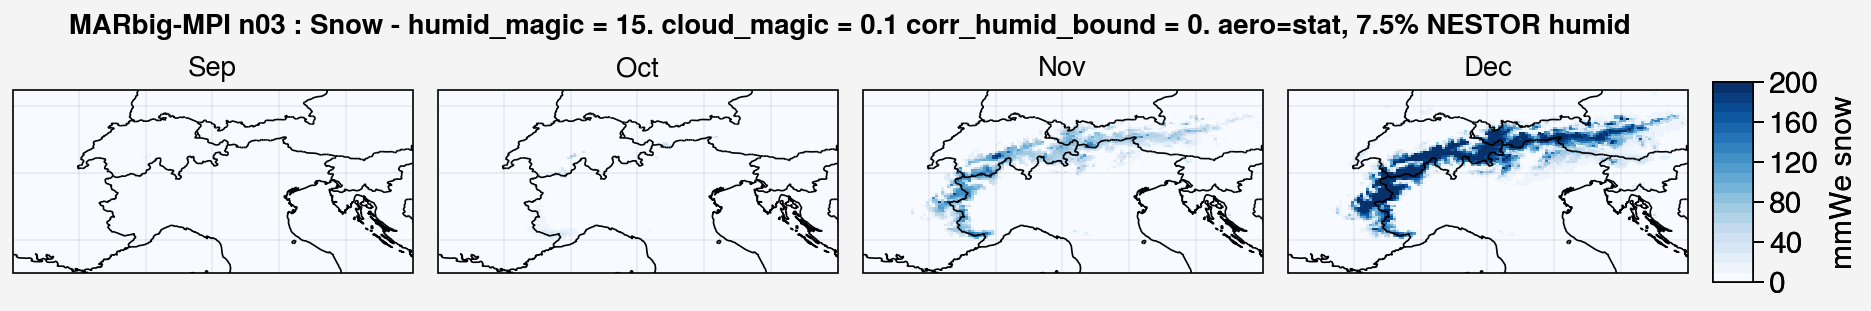

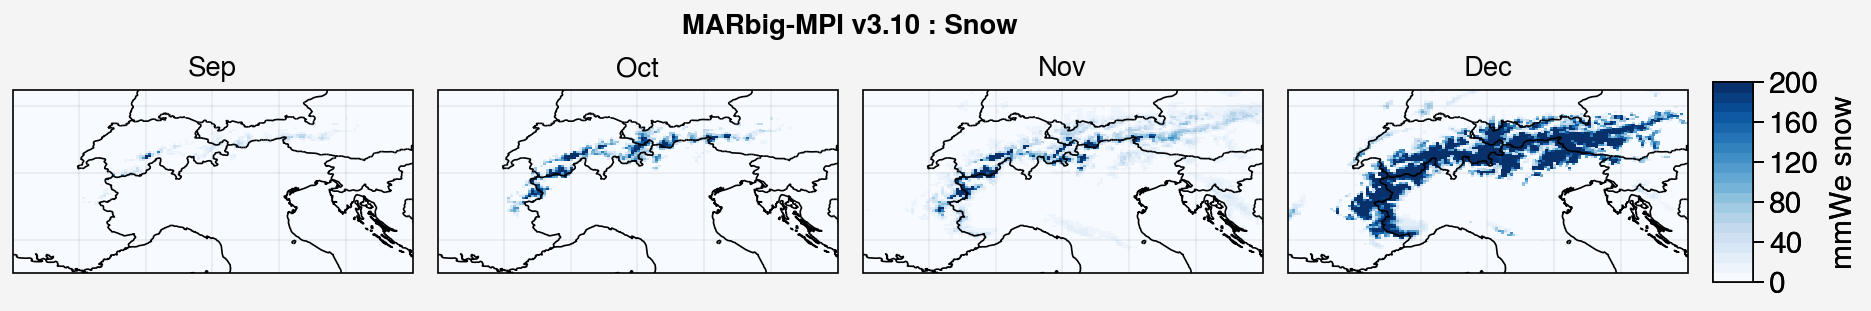

In [34]:
#n03 1960 vs v3.10 1961 (eye test)
plot_comparison(list_ds = ds_EUn031960.precip.groupby("time.month").mean(),
                months = ['Sep','Oct','Nov','Dec'],min = 0,max = 15,N=11,colormap = 'Blues',label_var = 'mm',
                suptitle_var = 'MARbig-MPI n03 : precip (rr and sf) - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = ds_EUy1961.precip.groupby("time.month").mean()[8:],
                months = ['Sep','Oct','Nov','Dec'],min = 0,max = 15,N=11,colormap = 'Blues',label_var = 'mm',
                suptitle_var = 'MARbig-MPI v3.10 : precip (rr and sf)',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))


plot_comparison(list_ds = ds_EUn031960.TTz.sel(ztqlev=2.0).groupby("time.month").mean(),
                months = ['Sep','Oct','Nov','Dec'],min = -15,max = 25,N=17,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARbig-MPI n03 : TTz 2m - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = ds_EUy1961.TTz.sel(ztqlev=2.0).groupby("time.month").mean()[8:],
                months = ['Sep','Oct','Nov','Dec'],min = -15,max = 25,N=17,colormap = 'RdBu_r',label_var = '°C',
                suptitle_var = 'MARbig-MPI v3.10 : TTz 2m',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))


plot_comparison(list_ds = ds_EUn031960.CC.groupby("time.month").mean(),
                months = ['Sep','Oct','Nov','Dec'],min = 0,max = 1,N=11,colormap = 'Blues',label_var = 'fraction cloud cover',
                suptitle_var = 'MARbig-MPI n03 : CC - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = ds_EUy1961.CC.groupby("time.month").mean()[8:],
                months = ['Sep','Oct','Nov','Dec'],min = 0,max = 1,N=11,colormap = 'Blues',label_var = 'fraction cloud cover',
                suptitle_var = 'MARbig-MPI v3.10 : CC',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))


plot_comparison(list_ds = ds_EUn031960.MB.max(axis=1).groupby("time.month").mean(),
                months = ['Sep','Oct','Nov','Dec'],min = 0,max = 200,N=21,colormap = 'Blues',label_var = 'mmWe snow',
                suptitle_var = 'MARbig-MPI n03 : Snow - humid_magic = 15. cloud_magic = 0.1 corr_humid_bound = 0. aero=stat, 7.5% NESTOR humid',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

plot_comparison(list_ds = ds_EUy1961.MB.max(axis=1).groupby("time.month").mean()[8:],
                months = ['Sep','Oct','Nov','Dec'],min = 0,max = 200,N=21,colormap = 'Blues',label_var = 'mmWe snow',
                suptitle_var = 'MARbig-MPI v3.10 : Snow',
                rows=1,cols=4,ds_size=ds_big.isel(y=slice(jmin,jmax),x=slice(imin,imax)))

## Surface balance trends

### Month by month

In [63]:
vars_list = ["SWU","SWD","LWU","LWD","SHF","LHF","MB","MBmTop","MBrTop","GF","HAcc","SWt","TTz"]
first_yr = 2016
last_yr = 2101 # that way loop goes to 2100
mon_nr = '05'
days_nr = '31'

sim_nr = 50 # simulation number

ds_mon_yrly = open_monthly_data_ave(vars=vars_list,year=str(2015),month=mon_nr,days_in_month=days_nr,sim='m50',timestep_in_hours = 4,
                               imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()

for yr in range(first_yr,last_yr):
    if sim_nr<10:
        sim_code = '0'+str(sim_nr)
    else:
        sim_code = str(sim_nr)
    if (yr+1)%2:
        sim_nr += 1
    if mon_nr=='02':
        if yr%4==0 and yr!=2100:
            days_nr = '29'
        else:
            days_nr = '28'
    print(sim_nr,end=' ')
    ds_mon = open_monthly_data_ave(vars=vars_list,year=str(yr),month=mon_nr,days_in_month=days_nr,sim='m'+sim_code,timestep_in_hours = 4,
                                   imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()
    ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon],dim="time")

51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59 60 60 61 61 62 62 63 63 64 64 65 65 66 66 67 67 68 68 69 69 70 70 71 71 72 72 73 73 74 74 75 75 76 76 77 77 78 78 79 79 80 80 81 81 82 82 83 83 84 84 85 85 86 86 87 87 88 88 89 89 90 90 91 91 92 92 93 

In [64]:
ds_mon_yrly.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_STlim30_May2015-2100_surfbal.npy')

In [65]:
vars_list = ["SWU","SWD","LWU","LWD","SHF","LHF","MB","MBmTop","MBrTop","GF","HAcc","SWt","TTz"]
first_yr = 2016
last_yr = 2101 # that way loop goes to 2100
mon_nr = '08'
days_nr = '31'

sim_nr = 50 # simulation number

ds_mon_yrly = open_monthly_data_ave(vars=vars_list,year=str(2015),month=mon_nr,days_in_month=days_nr,sim='m50',timestep_in_hours = 4,
                               imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()

for yr in range(first_yr,last_yr):
    if sim_nr<10:
        sim_code = '0'+str(sim_nr)
    else:
        sim_code = str(sim_nr)
    if (yr+1)%2:
        sim_nr += 1
    if mon_nr=='02':
        if yr%4==0 and yr!=2100:
            days_nr = '29'
        else:
            days_nr = '28'
    print(sim_nr,end=' ')
    ds_mon = open_monthly_data_ave(vars=vars_list,year=str(yr),month=mon_nr,days_in_month=days_nr,sim='m'+sim_code,timestep_in_hours = 4,
                                   imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()
    ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon],dim="time")

51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59 60 60 61 61 62 62 63 63 64 64 65 65 66 66 67 67 68 68 69 69 70 70 71 71 72 72 73 73 74 74 75 75 76 76 77 77 78 78 79 79 80 80 81 81 82 82 83 83 84 84 85 85 86 86 87 87 88 88 89 89 90 90 91 91 92 92 93 

In [66]:
ds_mon_yrly.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_STlim30_Aug2015-2100_surfbal.npy')

In [15]:
vars_list = ["SWU","SWD","LWU","LWD","SHF","LHF","MB","MBmTop","MBrTop","GF","HAcc","SWt","TTz"]
first_yr = 2016
last_yr = 2101 # that way loop goes to 2100
mon_nr = '04'
days_nr = '30'

sim_nr = 50 # simulation number

ds_mon_yrly = open_monthly_data_ave(vars=vars_list,year=str(2015),month=mon_nr,days_in_month=days_nr,sim='m02',timestep_in_hours = 4,
                               imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()

for yr in range(first_yr,last_yr):
    if sim_nr<10:
        sim_code = '0'+str(sim_nr)
    else:
        sim_code = str(sim_nr)
    if (yr+1)%2:
        sim_nr += 1
    if mon_nr=='02':
        if yr%4==0 and yr!=2100:
            days_nr = '29'
        else:
            days_nr = '28'
    print(sim_nr,end=' ')
    ds_mon = open_monthly_data_ave(vars=vars_list,year=str(yr),month=mon_nr,days_in_month=days_nr,sim='m'+sim_code,timestep_in_hours = 4,
                                   imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()
    ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon],dim="time")

3 3 4 4 5 5 6 6 7 7 8 8 9 9 10 10 11 11 12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36 37 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 

In [16]:
ds_mon_yrly.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Apr2015-2100_surfbal.npy')

In [52]:
ds_mon_yrly = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Nov2015-2100_surfbal.npy')
ds_mon_yrly

<xarray.Dataset>
Dimensions:     (time: 85, y: 90, x: 100, sector: 3, ztqlev: 3)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * sector      (sector) float32 1.0 2.0 3.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
  * time        (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2099-11-30
Data variables: (12/20)
    SWU         (time, y, x) float32 ...
    SWD         (time, y, x) float32 ...
    LWU         (time, y, x) float32 ...
    LWD         (time, y, x) float32 ...
    SHF         (time, y, x) float32 ...
    LHF         (time, y, x) float32 ...
    ...          ...
    freeze_top  (time, y, x) float32 ...
    MBave       (time, y, x) float32 ...
    NSW         (time, y, x) float32 ...
    NLW         (time, y, x) float32 ...
    TT2         (time, y, x) float32 ...
    Surf_Bal    (time, y, x) float32 ...
Attributes:
    title:        ICE - Exp: m02 - 20151101
    institution:  ULg (Xavier Fettweis)
    history:      libUN (2005.04.08) - Thu Jul  3 03:56:43 2025
    netcdf:       4.8.0 of May  2 2023 12:43:48 $

In [53]:
vars_list = ["SWU","SWD","LWU","LWD","SHF","LHF","MB","MBmTop","MBrTop","GF","HAcc","SWt","TTz"]
mon_nr = '11'
days_nr = '30'


ds_mon = open_monthly_data_ave(vars=vars_list,year=str(2100),month=mon_nr,days_in_month=days_nr,sim='m44',timestep_in_hours = 4,
                               imin = 0, imax = None, jmin = 0, jmax = None, whichpath='castelli', combine=False,ds_sect=ds_smallish).resample(time='M').mean()

ds_mon_yrly = xr.concat([ds_mon_yrly,ds_mon],dim="time")

In [54]:
ds_mon_yrly

<xarray.Dataset>
Dimensions:     (time: 86, y: 90, x: 100, sector: 3, ztqlev: 3)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * sector      (sector) float32 1.0 2.0 3.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
  * time        (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2100-11-30
Data variables: (12/20)
    SWU         (time, y, x) float32 0.0 11.65 11.65 11.65 ... 7.717 7.719 0.0
    SWD         (time, y, x) float32 0.0 116.5 116.5 116.5 ... 77.17 77.19 0.0
    LWU         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LWD         (time, y, x) float32 0.0 296.9 296.6 297.0 ... 264.1 264.2 0.0
    SHF         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LHF         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    freeze_top  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MBave       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NSW         (time, y, x) float32 0.0 104.9 104.9 104.8 ... 69.46 69.47 0.0
    NLW         (time, y, x) float32 0.0 296.9 296.6 297.0 ... 264.1 264.2 0.0
    TT2         (time, y, x) float32 15.58 15.56 15.55 ... 6.76 6.785 6.777
    Surf_Bal    (time, y, x) float32 0.0 401.8 401.5 401.8 ... 333.5 333.7 0.0
Attributes:
    title:        ICE - Exp: m02 - 20151101
    institution:  ULg (Xavier Fettweis)
    history:      libUN (2005.04.08) - Thu Jul  3 03:56:43 2025
    netcdf:       4.8.0 of May  2 2023 12:43:48 $

In [55]:
ds_mon_yrly.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Nov2015-2100_surfbal.npy')

In [85]:
def plot_monthly_2points(ds_var,first,last,iloc1,jloc1,iloc2,jloc2,ymin,ymax,names_var,colors,titleoffig):
# ------------------------------------------------- Map ------------------------------------------------
        
    colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
    f, ax = pplt.subplots(proj='cyl', axwidth=5)
    m=ax.pcolormesh(ds_smallish.LON, ds_smallish.LAT, ds_smallish.SH, levels=17,cmap=colors_land)
    f.colorbar(m,label= 'm.a.s.l.',labelsize='large',ticklabelsize='large')

    ax.plot(ds_smallish.LON[iloc1,jloc1], ds_smallish.LAT[iloc1,jloc1],'rx',markersize=8,markeredgewidth=1.5)
    ax.plot(ds_smallish.LON[iloc2,jloc2], ds_smallish.LAT[iloc2,jloc2],'bx',markersize=8,markeredgewidth=1.5)

    ax.format(**normal_format)
    ax.format(ocean=True,oceancolor='royalblue',reso='hi')

# ------------------------------------------------- Time series plots ------------------------------------------------

    #longitude_point = round(float(lon[iloc,jloc]),2)
    #latitude_point = round(float(lat[iloc,jloc]),2)
    f, axs = pplt.subplots(axwidth=5,axheight=0.4,ncols=2,nrows=2,hratios=(1,5),ref=1,sharey=False)
    pplt.rc.update(small=10, large=12)
    
    #ds_var_ave['Surf_Bal_HA_col'] = ds_var_ave.NSW + ds_var_ave.NLW + ds_var_ave.SHF + ds_var_ave.LHF + ds_var_ave.melt + ds_var_ave.freeze + ds_var_ave.HA_col
    #ds_var['Surf_Bal_HA_colk'] = ds_var.NSWk + ds_var.NLWk + ds_var.SHFk + ds_var.LHFk + ds_var.meltk + ds_var.freezek + ds_var.HA_colk

    for i,var in enumerate(names_var):
        if(var=='Surf_Bal' or var=='Surf_Bal_HA_col'):
            line_width=2.5
        else:
            line_width=1
        ax=axs[2]
        ax.set_ylim([ymin,ymax])
        ax.format(ylabel='W/$m^2$')
        ax.scatter(ds_var.time[first:last], np.array(ds_var[var])[first:last,iloc1,jloc1], c=colors[i], s=10)
        ax.plot(ds_var.time[first:last], np.array(ds_var[var])[first:last,iloc1,jloc1], c=colors[i],linewidth=line_width)
        
        ax=axs[3]
        ax.set_ylim([ymin,ymax])
        ax.scatter(ds_var.time[first:last], np.array(ds_var[var])[first:last,iloc2,jloc2], c=colors[i], s=10)
        ax.plot(ds_var.time[first:last], np.array(ds_var[var])[first:last,iloc2,jloc2], c=colors[i],linewidth=line_width,label=var)


    max_MB = max(np.array(ds_var['MB'])[first:last,:,iloc1,jloc1].max(), np.array(ds_var['MB'])[:,first:last,iloc2,jloc2].max())
    ax=axs[0]
    ax.format(title='Point 1 (red)',ylabel='Snow \n(mmWe)')
    ax.set_ylim([-0.1,max_MB])
    ax.plot(ds_var.time[first:last], np.array(ds_var['MB'].max(axis=1))[first:last,iloc1,jloc1], c='skyblue',linewidth=line_width)

    max_MB = np.array(ds_var['MB'])[first:last,:,iloc2,jloc2].max()
    ax=axs[1]
    ax.format(title='Point 2 (blue)')
    ax.plot(ds_var.time[first:last], np.array(ds_var['MB'].max(axis=1))[first:last,iloc2,jloc2], c='skyblue',linewidth=line_width)

    #f.format(titlesize='20px',suptitle=f'Gridpoint (lon {longitude_point}°, lat {latitude_point}°)')
    f.legend(loc='b',prop = { "size": 10 },ncols=4)
    f.format(suptitle=titleoffig)

In [54]:
ds_Feb = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Feb_surfbal.npy')

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_238183/1224452565.py:20: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=10, large=12)
/tmp/ipykernel_238183/1224452565.py:20: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=10, large=12)


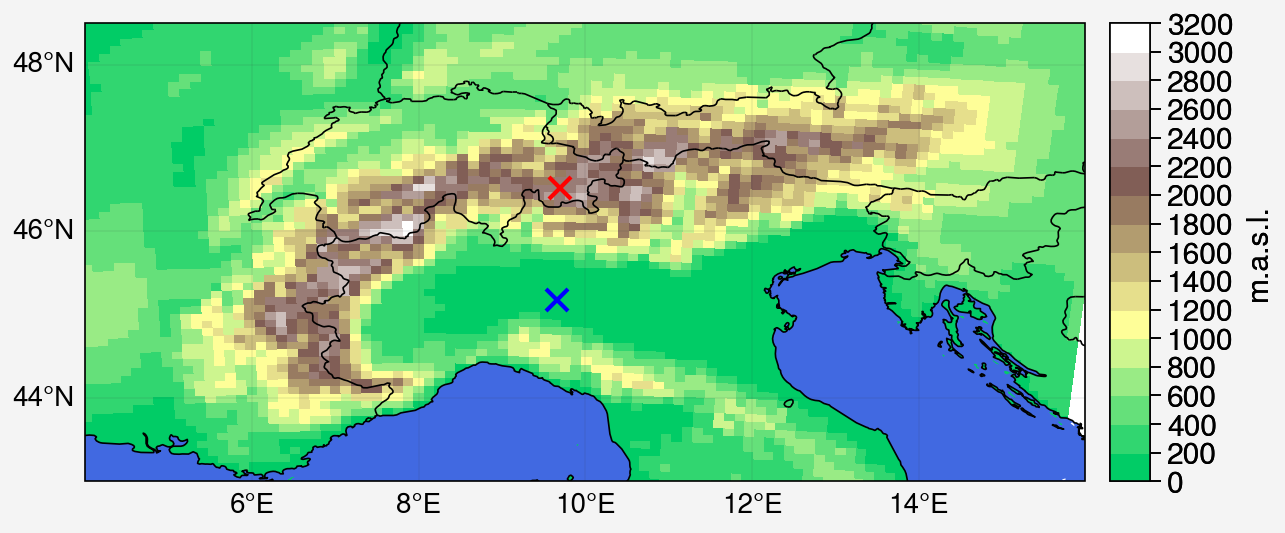

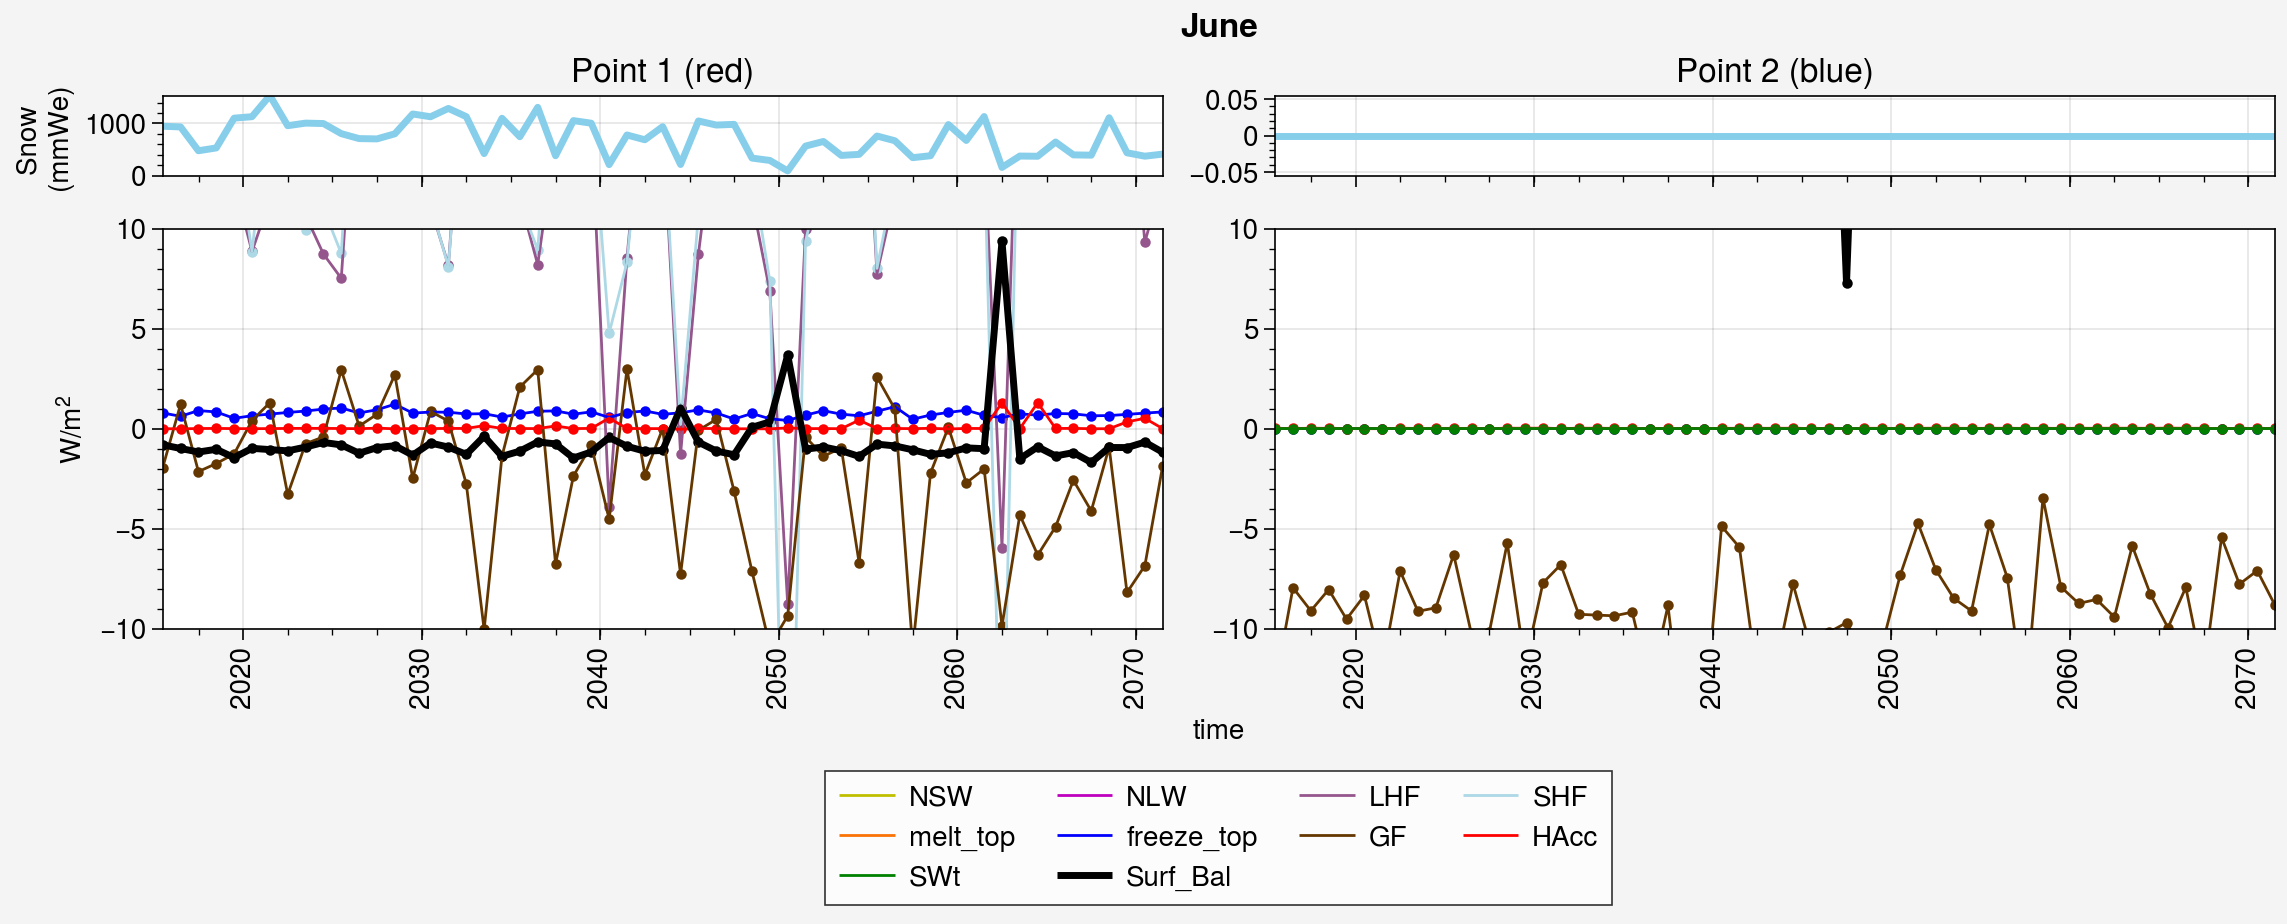

In [88]:
plot_monthly_2points(ds_mon_yrly, first=0, last=None, iloc1=50, jloc1=50, iloc2=35, jloc2=50, ymin=-10, ymax=10,
                     names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surf_Bal'],
                     colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k'],titleoffig='June')

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_238183/1224452565.py:20: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=10, large=12)
/tmp/ipykernel_238183/1224452565.py:20: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=10, large=12)


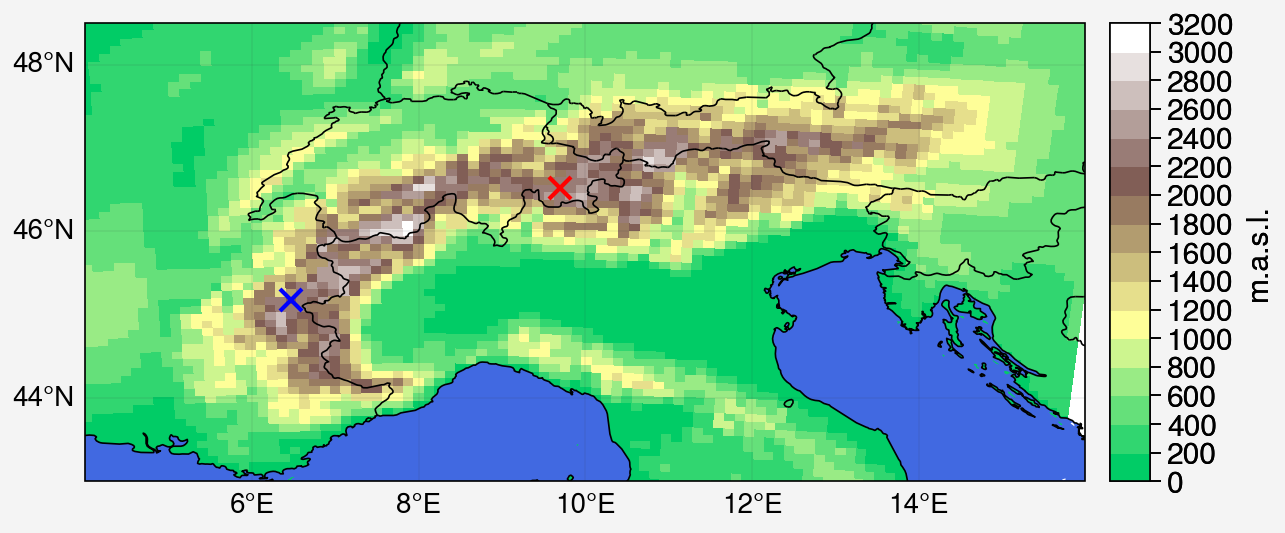

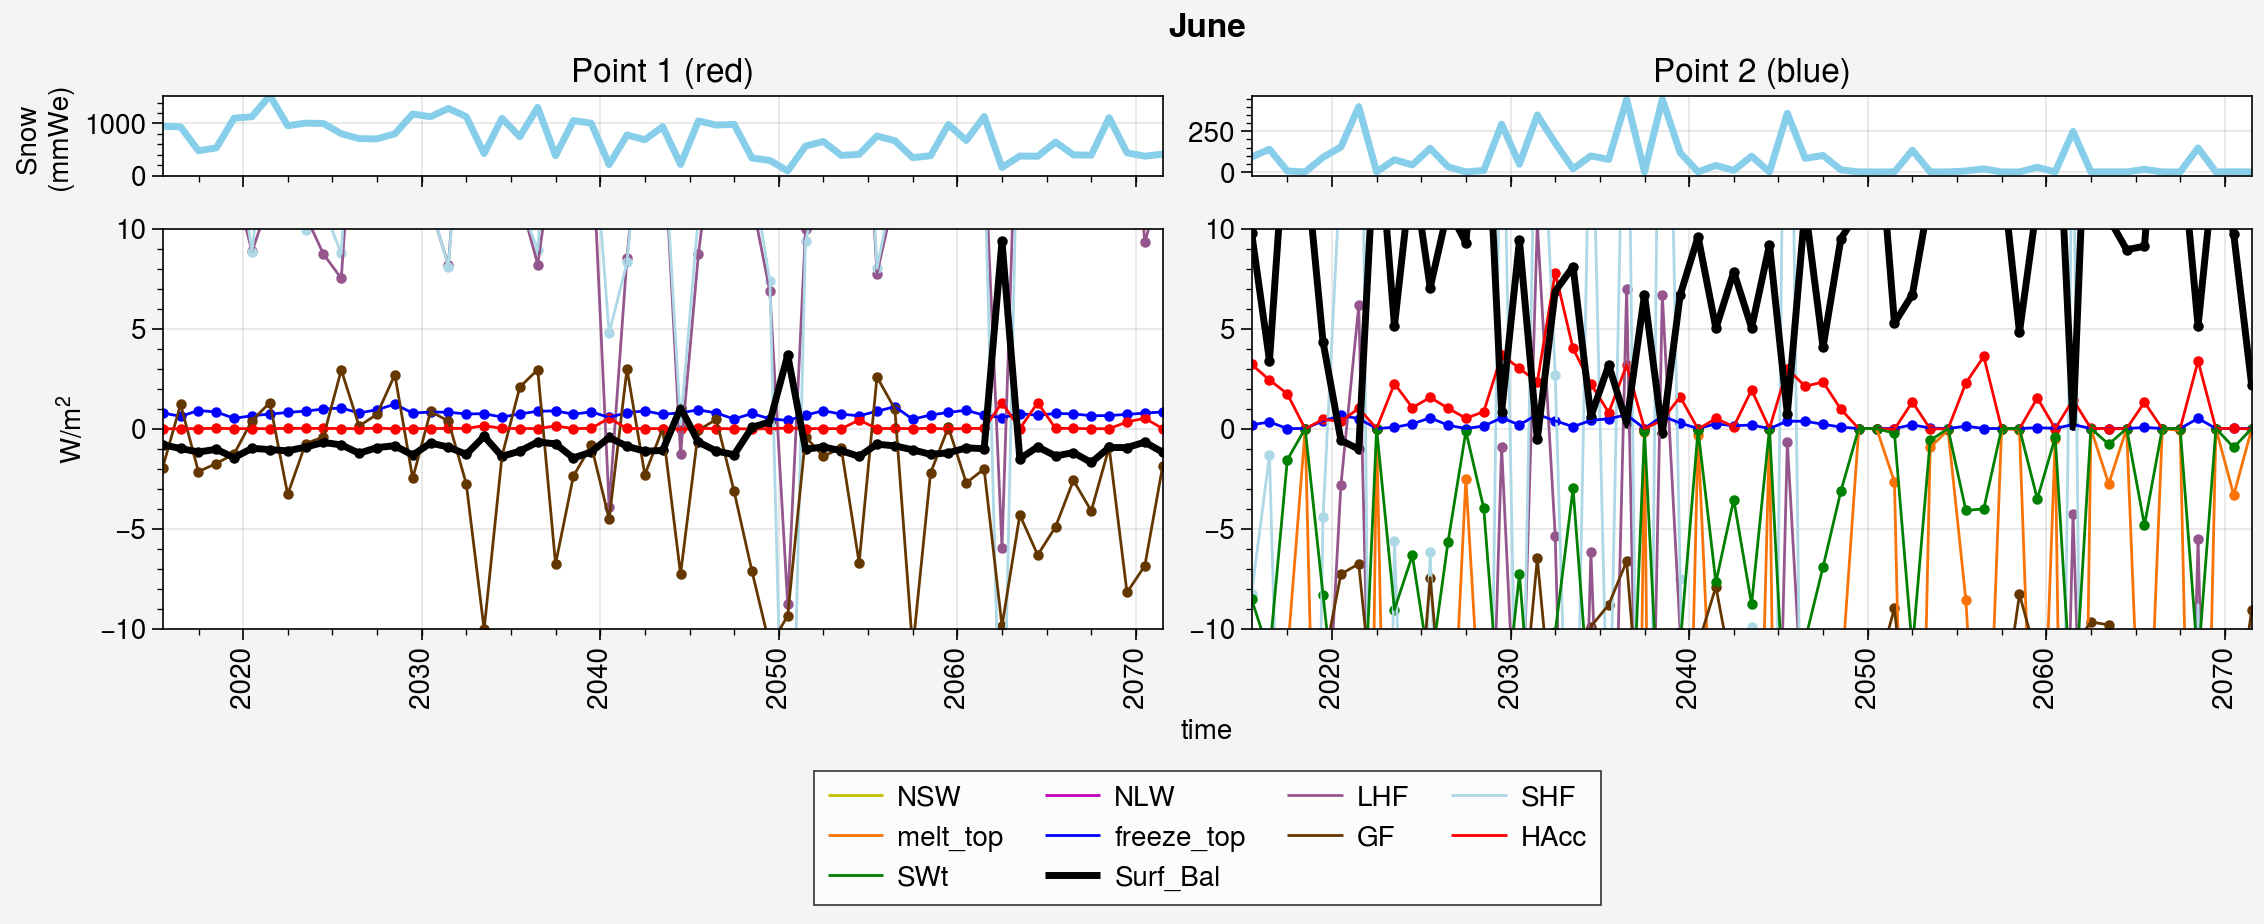

In [103]:
plot_monthly_2points(ds_mon_yrly, first=0, last=None, iloc1=50, jloc1=50, iloc2=35, jloc2=25, ymin=-10, ymax=10,
                     names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surf_Bal'],
                     colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k'],titleoffig='June')

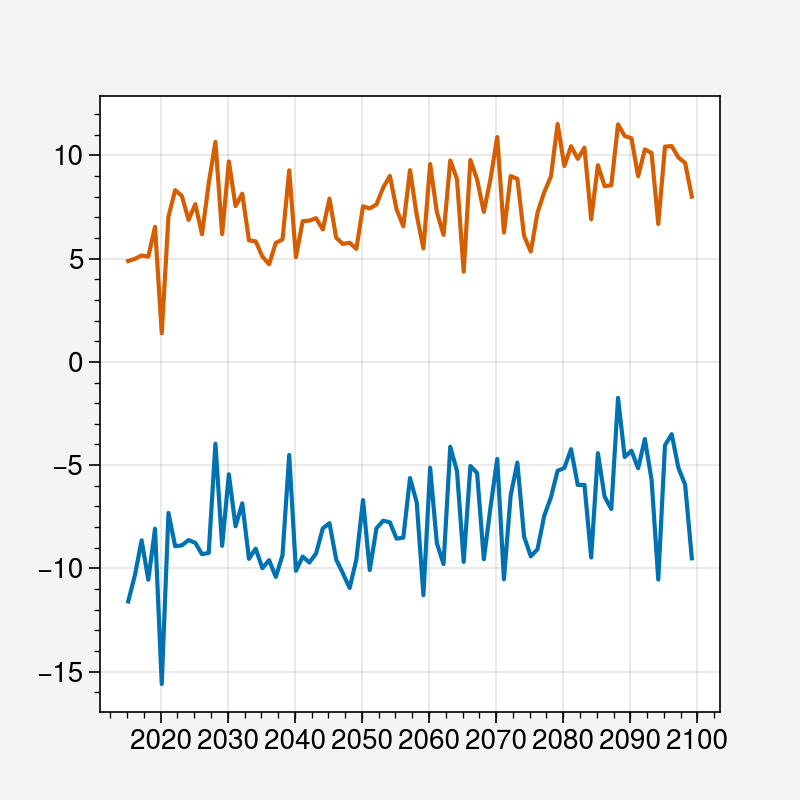

In [68]:
plt.plot(ds_Feb.time[:], np.array(ds_Feb['TTz'].sel(ztqlev=2))[:,50,50])

plt.plot(ds_Feb.time[:], np.array(ds_Feb['TTz'].sel(ztqlev=2))[:,35,50])

## As a function of altitude

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


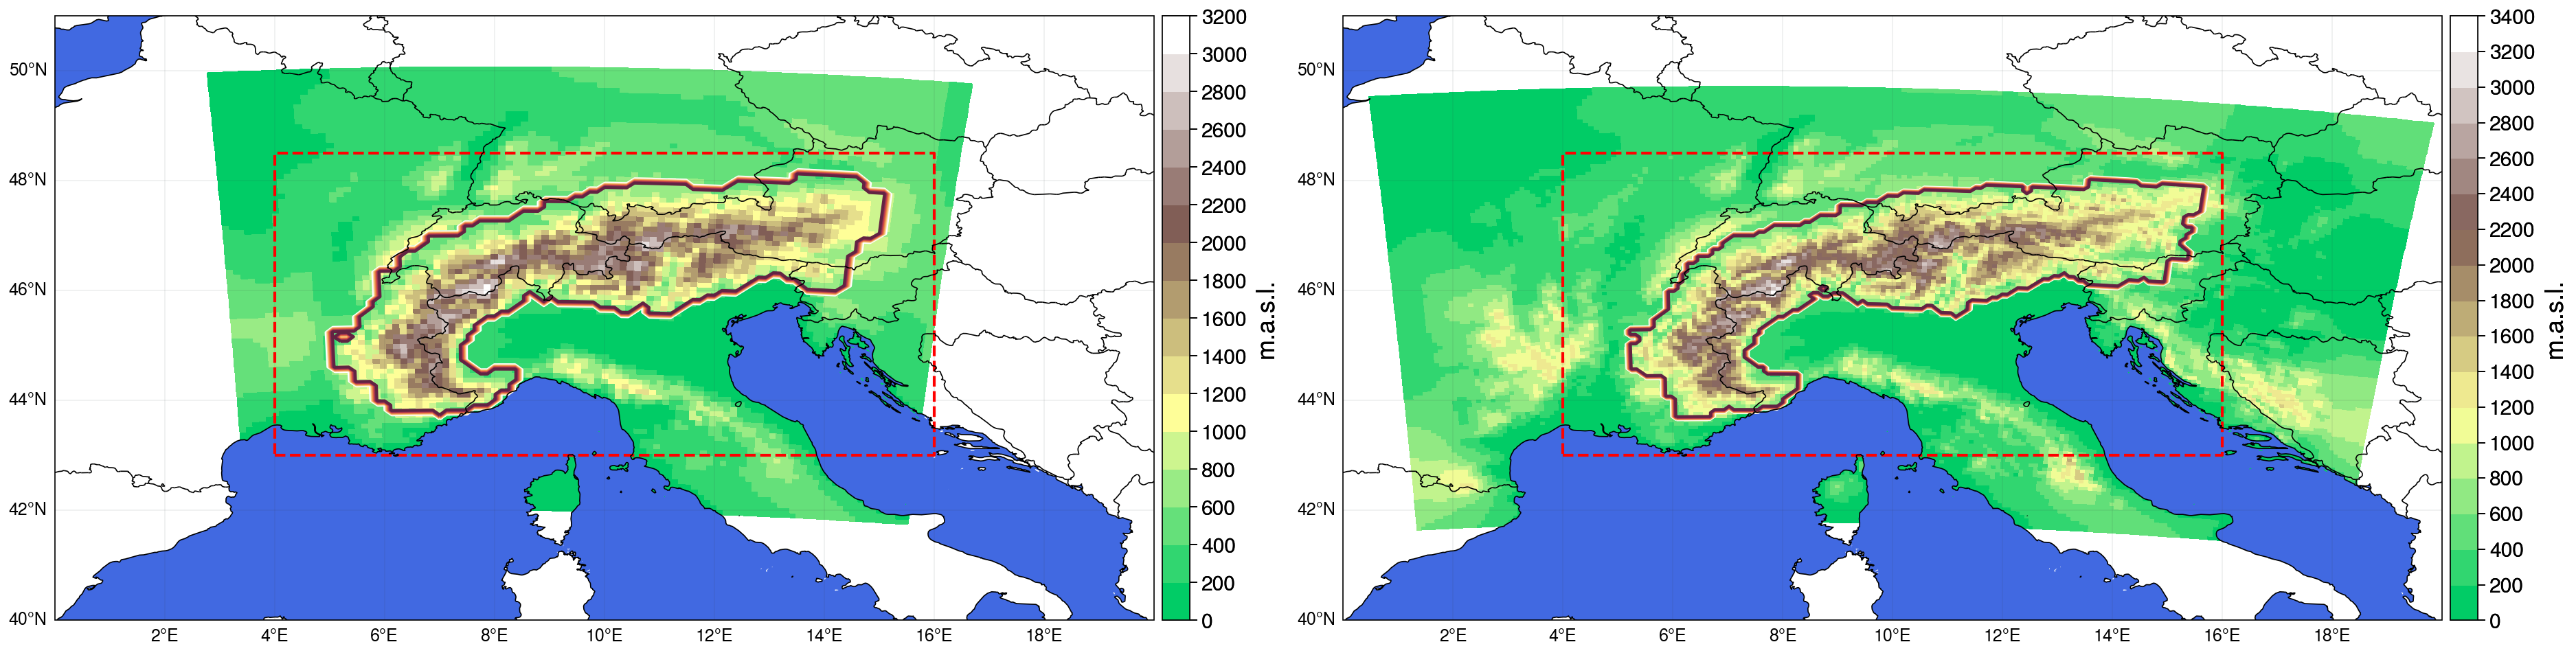

In [11]:
pplt.rc['figure.facecolor'] = 'white'

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)
m=axs[0].pcolormesh(ds_smallish.LON, ds_smallish.LAT, ds_smallish.SH, levels=17,cmap=colors_land)
axs[0].colorbar(m,label= 'm.a.s.l.',labelsize='x-large',ticklabelsize='large')
axs[0].plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')
axs[0].contour(lon_smallish, lat_smallish, alps_smallish)

m=axs[1].pcolormesh(ds.LON, ds.LAT, ds.SH, levels=17,cmap=colors_land)
axs[1].colorbar(m,label= 'm.a.s.l.',labelsize='x-large',ticklabelsize='large')
axs[1].plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')
axs[1].contour(lon, lat, alps)

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])


In [11]:
# creating seasonal dataarray with all vars
ds_sect = ds_big
Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
t_timestep = 60*60*24 # 60*60*24 seconds in a day

#path = '/bettik/castelli/data/MAR-MPI-ESM/v3.14/STlim30/SSP585/'
path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/'
simcode = 'y'

ds_yrs = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LWD.2015.nc')#.resample(time='D').mean()

ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LWU.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(LWU = ds_var['LWU'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SWD.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(SWD = ds_var['SWD'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SWU.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(SWU = ds_var['SWU'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SHF.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(SHF = ds_var['SHF'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LHF.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(LHF = ds_var['LHF'])
# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.GF.2015.nc').resample(time='D').mean()
# ds_yrs = ds_yrs.assign(GF = ds_var['GF'])
# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.HAcc.2015.nc').resample(time='D').mean()
# ds_yrs = ds_yrs.assign(HAcc = ds_var['HAcc'])
# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.SWt.2015.nc').resample(time='D').mean()
# ds_yrs = ds_yrs.assign(SWt = ds_var['SWt'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTz.2015.nc').resample(time='D').mean()
ds_yrs = ds_yrs.assign(TTz = ds_var['TTz'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.MB.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(MB = ds_var['MB'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTmin.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(TTmin = ds_var['TTmin'])
ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTmax.2015.nc')#.resample(time='D').mean()
ds_yrs = ds_yrs.assign(TTmax = ds_var['TTmax'])

# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.MBm.2015.nc')#.resample(time='D').sum()
# melt_MBm_top = ds_var.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_var.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
#                 ds_var.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
# ds_day_melt_top = melt_MBm_top * Lf / t_timestep
# ds_yrs = ds_yrs.assign(melt_top = -ds_day_melt_top) # minus sign becausemelt energy is lost from surface
# ends up with sector = 3 as acoordinate but doesn't really correspond to anything(it's actually summed over the sectors)

ds_var = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/SSP585/ICE.MPI-ESM_SSP585.EU'+simcode+'.MBm.2015.nc')#.resample(time='D').sum()
melt_MBm_top = ds_var.MBm.sel(sector=1.0)*np.array(ds_sect.FRV.sel(sector=1.0))/100 + ds_var.MBm.sel(sector=2.0)*np.array(ds_sect.FRV.sel(sector=2.0))/100 + \
                ds_var.MBm.sel(sector=3.0)*np.array(ds_sect.FRV.sel(sector=3.0))/100
ds_day_melt_top = melt_MBm_top * Lf / t_timestep
ds_yrs = ds_yrs.assign(melt = -ds_day_melt_top) # minus sign becausemelt energy is lost from surface

# ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.MBrTop.2015.nc')#.resample(time='D').sum()
# freez_MBr_top = ds_var.MBrTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_var.MBrTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
#                 ds_var.MBrTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
# ds_day_freez_top = freez_MBr_top * Lf / t_timestep
# ds_yrs = ds_yrs.assign(freeze_top = ds_day_freez_top)

ds_yrs = season_mean(ds_yrs)

for year in range(2016,2101):
    print(year,end=' ')
    ds_singleyr = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LWD.'+str(year)+'.nc')#.resample(time='D').mean()

    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LWU.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(LWU = ds_var['LWU'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SWD.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(SWD = ds_var['SWD'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SWU.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(SWU = ds_var['SWU'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.SHF.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(SHF = ds_var['SHF'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.LHF.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(LHF = ds_var['LHF'])
    # ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.GF.'+str(year)+'.nc').resample(time='D').mean()
    # ds_singleyr = ds_singleyr.assign(GF = ds_var['GF'])
    # ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.HAcc.'+str(year)+'.nc').resample(time='D').mean()
    # ds_singleyr = ds_singleyr.assign(HAcc = ds_var['HAcc'])
    # ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.SWt.'+str(year)+'.nc').resample(time='D').mean()
    # ds_singleyr = ds_singleyr.assign(SWt = ds_var['SWt'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTz.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(TTz = ds_var['TTz'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.MB.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(MB = ds_var['MB'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTmin.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(TTmin = ds_var['TTmin'])
    ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EU'+simcode+'.TTmax.'+str(year)+'.nc')#.resample(time='D').mean()
    ds_singleyr = ds_singleyr.assign(TTmax = ds_var['TTmax'])
    

    # ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.MBmTop.'+str(year)+'.nc').resample(time='D').sum()
    # melt_MBm_top = ds_var.MBmTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_var.MBmTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
    #             ds_var.MBmTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
    # ds_day_melt_top = melt_MBm_top * Lf / t_timestep
    # ds_singleyr = ds_singleyr.assign(melt_top = -ds_day_melt_top) # minus sign becausemelt energy is lost from surface

    ds_var = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/SSP585/ICE.MPI-ESM_SSP585.EU'+simcode+'.MBm.'+str(year)+'.nc')#.resample(time='D').sum()
    melt_MBm_top = ds_var.MBm.sel(sector=1.0)*np.array(ds_sect.FRV.sel(sector=1.0))/100 + ds_var.MBm.sel(sector=2.0)*np.array(ds_sect.FRV.sel(sector=2.0))/100 + \
                ds_var.MBm.sel(sector=3.0)*np.array(ds_sect.FRV.sel(sector=3.0))/100
    ds_day_melt_top = melt_MBm_top * Lf / t_timestep
    ds_singleyr = ds_singleyr.assign(melt = -ds_day_melt_top) # minus sign becausemelt energy is lost from surface
    
    # ds_var = xr.open_dataset(path+'ICE.MPI-ESM_SSP585.EUm.MBrTop.'+str(year)+'.nc').resample(time='D').sum()
    # freez_MBr_top = ds_var.MBrTop.sel(sector=1.0)*ds_sect.FRV.sel(sector=1.0)/100 + ds_var.MBrTop.sel(sector=2.0)*ds_sect.FRV.sel(sector=2.0)/100 + \
    #             ds_var.MBrTop.sel(sector=3.0)*ds_sect.FRV.sel(sector=3.0)/100
    # ds_day_freez_top = freez_MBr_top * Lf / t_timestep
    # ds_singleyr = ds_singleyr.assign(freeze_top = ds_day_freez_top)
    print('Computing season mean')
    ds_singleyr = season_mean(ds_singleyr)
    ds_yrs = xr.concat([ds_yrs,ds_singleyr], dim='Year')
    


2016 Computing season mean
2017 Computing season mean
2018 Computing season mean
2019 Computing season mean
2020 Computing season mean
2021 Computing season mean
2022 Computing season mean
2023 Computing season mean
2024 Computing season mean
2025 Computing season mean
2026 Computing season mean
2027 Computing season mean
2028 Computing season mean
2029 Computing season mean
2030 Computing season mean
2031 Computing season mean
2032 Computing season mean
2033 Computing season mean
2034 Computing season mean
2035 Computing season mean
2036 Computing season mean
2037 Computing season mean
2038 Computing season mean
2039 Computing season mean
2040 Computing season mean
2041 Computing season mean
2042 Computing season mean
2043 Computing season mean
2044 Computing season mean
2045 Computing season mean
2046 Computing season mean
2047 Computing season mean
2048 Computing season mean
2049 Computing season mean
2050 Computing season mean
2051 Computing season mean
2052 Computing season mean
2

In [12]:
ds_yrs.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/ds_Surfbal_vars_2015_2100_seas.npy')

In [20]:
ds_yrs = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/smallishdomain/ds_Surfbal_vars_2015_2100.npy')

ds_yrs

<xarray.Dataset>
Dimensions:     (x: 100, y: 90, ztqlev: 3, Year: 86, season: 4)
Coordinates:
  * x           (x) float32 -370.0 -360.0 -350.0 -340.0 ... 600.0 610.0 620.0
  * y           (y) float32 -440.0 -430.0 -420.0 -410.0 ... 430.0 440.0 450.0
  * ztqlev      (ztqlev) float32 2.0 10.0 100.0
    sector      float32 ...
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: Year
Data variables:
    LWD         (Year, season, y, x) float64 ...
    LWU         (Year, season, y, x) float64 ...
    SWD         (Year, season, y, x) float64 ...
    SWU         (Year, season, y, x) float64 ...
    SHF         (Year, season, y, x) float64 ...
    LHF         (Year, season, y, x) float64 ...
    GF          (Year, season, y, x) float64 ...
    HAcc        (Year, season, y, x) float64 ...
    SWt         (Year, season, y, x) float64 ...
    TTz         (Year, season, ztqlev, y, x) float64 ...
    melt_top    (Year, season, y, x) float64 ...
    freeze_top  (Year, season, y, x) float64 ...

In [21]:
yrs = np.arange(2015,2101)

ds_yrs = ds_yrs.assign_coords(Year=("Year", yrs))

ds_yrs['NSW'] = ds_yrs['SWD'] - ds_yrs['SWU']
ds_yrs['NLW'] = ds_yrs['LWD'] - ds_yrs['LWU']
ds_yrs['Surfbal'] = ds_yrs['NSW'] + ds_yrs['NLW'] + ds_yrs['SHF'] + ds_yrs['LHF'] + ds_yrs['GF'] + ds_yrs['HAcc'] + ds_yrs['SWt'] + ds_yrs['melt_top'] \
                    + ds_yrs['freeze_top']

In [35]:
ds_slopes = ds_yrs.polyfit('Year', deg=1)
ds_slopes

<xarray.Dataset>
Dimensions:                          (season: 4, y: 90, x: 100, degree: 2,
                                      ztqlev: 3)
Coordinates:
  * season                           (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * y                                (y) float32 -440.0 -430.0 ... 440.0 450.0
  * x                                (x) float32 -370.0 -360.0 ... 610.0 620.0
  * degree                           (degree) int64 1 0
  * ztqlev                           (ztqlev) float32 2.0 10.0 100.0
Data variables: (12/15)
    LWD_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    LWU_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    SWD_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    SWU_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    SHF_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    LHF_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    ...                               ...
    TTz_polyfit_coefficients         (degree, season, ztqlev, y, x) float64 0...
    melt_top_polyfit_coefficients    (degree, season, y, x) float64 0.0 ... 0.0
    freeze_top_polyfit_coefficients  (degree, season, y, x) float64 0.0 ... 0.0
    NSW_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    NLW_polyfit_coefficients         (degree, season, y, x) float64 0.0 ... 0.0
    Surfbal_polyfit_coefficients     (degree, season, y, x) float64 0.0 ... 0.0

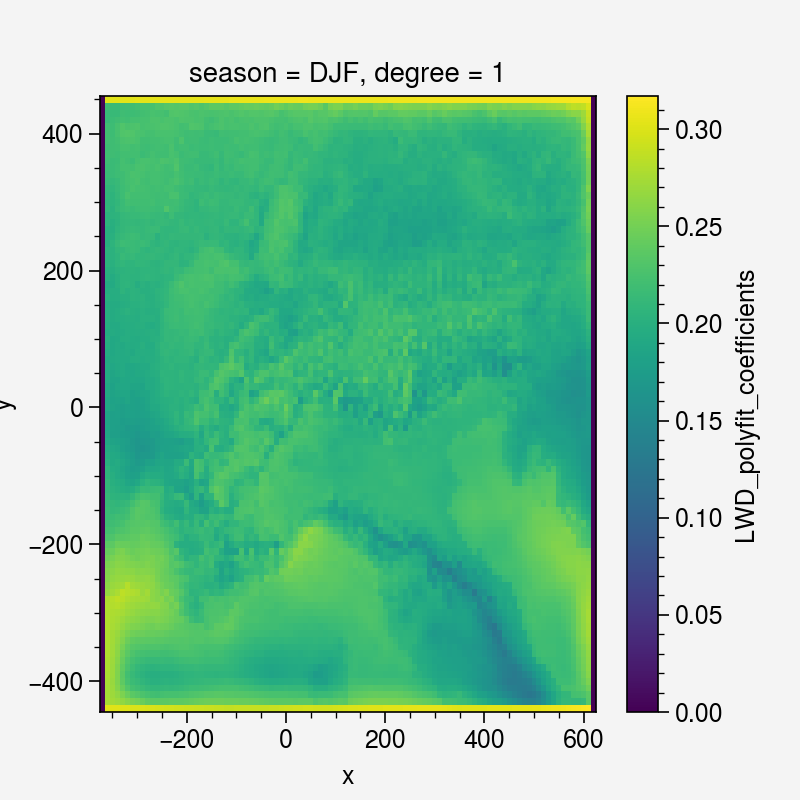

In [37]:
ds_slopes.LWD_polyfit_coefficients.sel(season='DJF').sel(degree=1).plot()

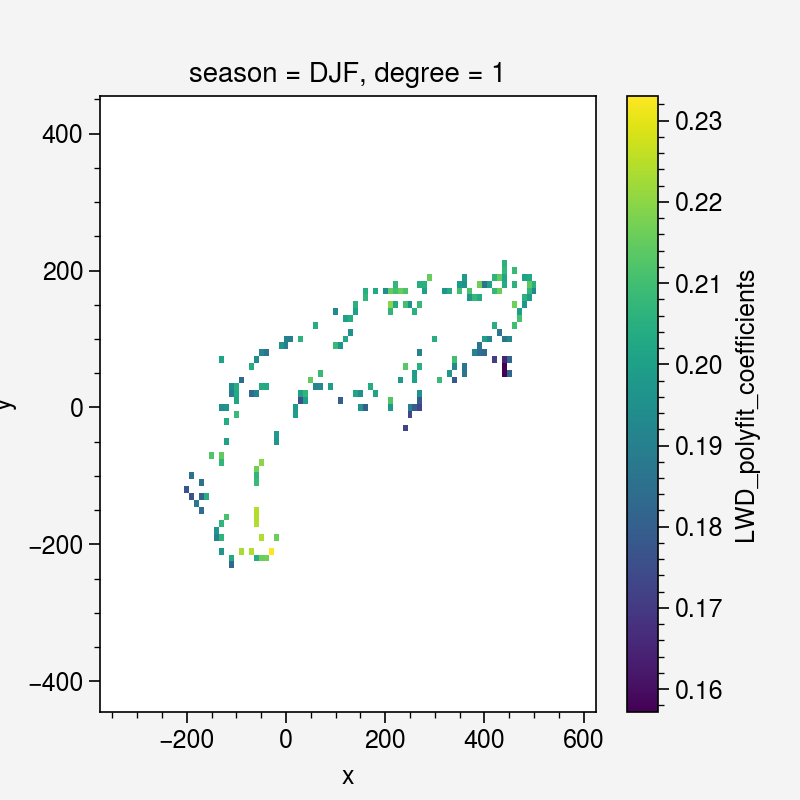

In [42]:
ds_slopes.LWD_polyfit_coefficients.sel(season='DJF',degree=1).where(levels[5]).plot()

In [ ]:
ds_yrs = xr.concat([ds_yrs,ds_singleyr], dim='Year')

In [23]:
# Levels (altitude bands)

alps = alps_smallish
H = ds_smallish.SH

levels = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]

H_levels = [300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100]

In [59]:
ds_slopes_Hlev = ds_slopes.where(levels[0]).mean(dim=('x','y'))
ds_slopes_Hlev_std = ds_slopes.where(levels[0]).std(dim=('x','y'))

for lev in range(1,len(levels)):
    ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,ds_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
    ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,ds_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", H_levels))
ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", H_levels))

In [61]:
ds_slopes_Hlev

<xarray.Dataset>
Dimensions:                          (Hlev: 15, degree: 2, season: 4, ztqlev: 3)
Coordinates:
  * season                           (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * degree                           (degree) int64 1 0
  * ztqlev                           (ztqlev) float32 2.0 10.0 100.0
  * Hlev                             (Hlev) int64 300 500 700 ... 2700 2900 3100
Data variables: (12/15)
    LWD_polyfit_coefficients         (Hlev, degree, season) float64 0.2141 .....
    LWU_polyfit_coefficients         (Hlev, degree, season) float64 0.2244 .....
    SWD_polyfit_coefficients         (Hlev, degree, season) float64 -0.005736...
    SWU_polyfit_coefficients         (Hlev, degree, season) float64 -0.007939...
    SHF_polyfit_coefficients         (Hlev, degree, season) float64 -0.008777...
    LHF_polyfit_coefficients         (Hlev, degree, season) float64 -0.000608...
    ...                               ...
    TTz_polyfit_coefficients         (Hlev, degree, season, ztqlev) float64 0...
    melt_top_polyfit_coefficients    (Hlev, degree, season) float64 0.009918 ...
    freeze_top_polyfit_coefficients  (Hlev, degree, season) float64 -0.000683...
    NSW_polyfit_coefficients         (Hlev, degree, season) float64 0.002203 ...
    NLW_polyfit_coefficients         (Hlev, degree, season) float64 -0.01036 ...
    Surfbal_polyfit_coefficients     (Hlev, degree, season) float64 -0.01759 ...

In [70]:
ds_slopes_Hlev['TTz_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)

<xarray.DataArray 'TTz_polyfit_coefficients' (Hlev: 15)>
array([0.05000764, 0.05040918, 0.05114425, 0.05160947, 0.05162136,
       0.05197469, 0.05238076, 0.05281676, 0.05354883, 0.05439117,
       0.05554345, 0.05631062, 0.05728061, 0.06107313, 0.06435595])
Coordinates:
    season   <U3 'SON'
    degree   int64 1
    ztqlev   float32 2.0
  * Hlev     (Hlev) int64 300 500 700 900 1100 1300 ... 2300 2500 2700 2900 3100

In [ ]:
names_var = ['NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surf_Bal'],
                     colors = ['y','m','purple','lightblue','orange','blue','brown','r','green','k']

/tmp/ipykernel_238183/3908700639.py:9: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_238183/3908700639.py:9: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)


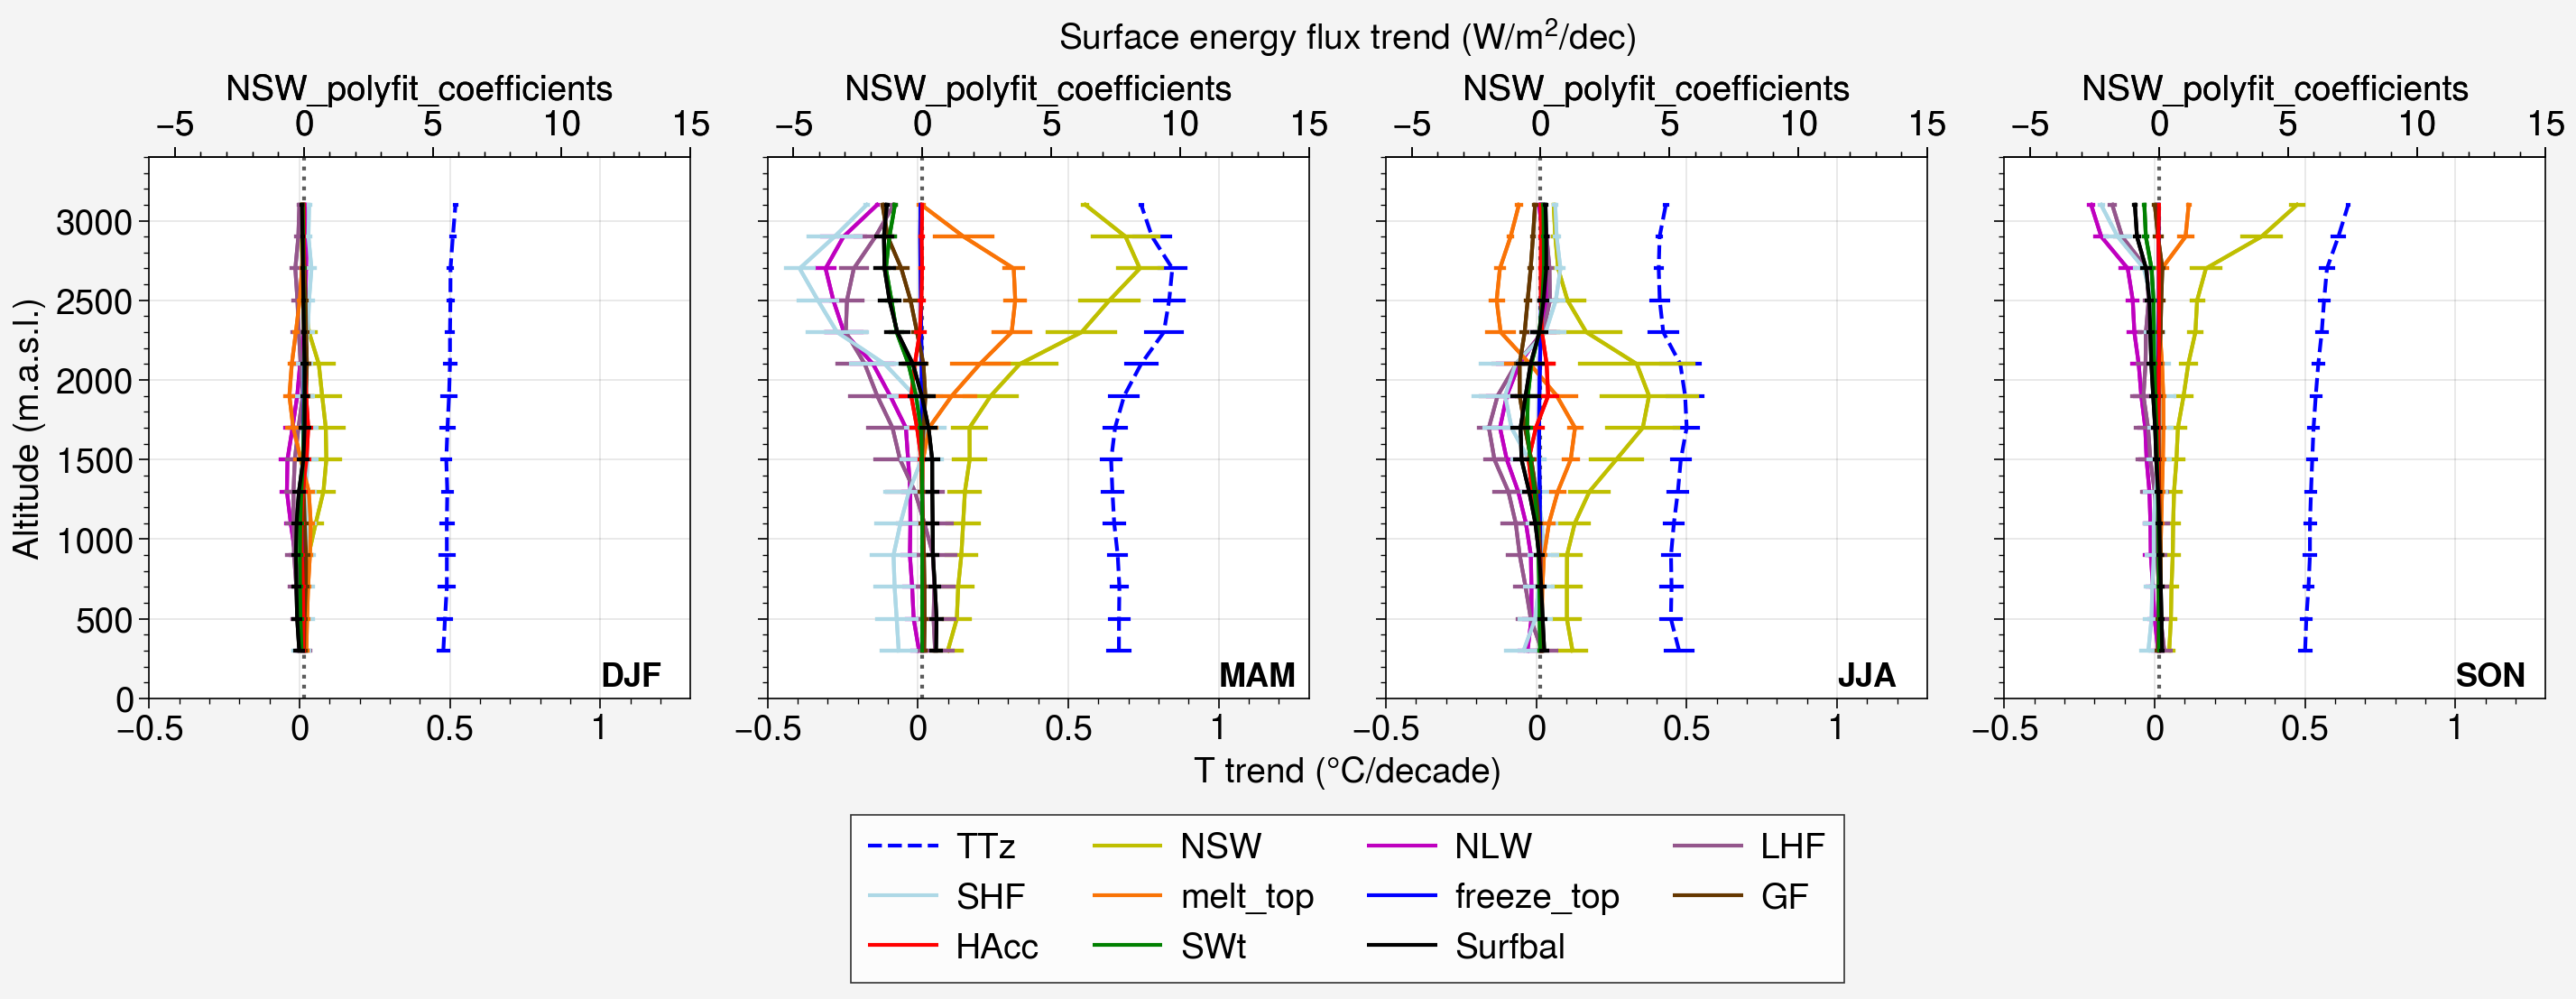

In [72]:
seasons=['DJF','MAM','JJA','SON']
colors = ['b','y','m','purple','lightblue','orange','blue','brown','r','green','k']
leg_labels_null = ['','','','','','','','','','','']
leg_labels_full = ['TTz','NSW','NLW','LHF','SHF','melt_top','freeze_top','GF','HAcc','SWt','Surfbal']
leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]

multiplier = 10 # =10 if trends per decade

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='TTz':
            ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0),H_levels,c=colors[i],linestyle='--',
                    label=leg_labels[seas][i])
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i])
        for lev in range(len(levels)): # spatial standard deviation
            if var=='TTz':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
    ax.set_xlim(-0.5,1.3)
    ax.text(1., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-6,15)

f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/dec)'

axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle)

/tmp/ipykernel_238183/693237815.py:9: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_238183/693237815.py:9: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)


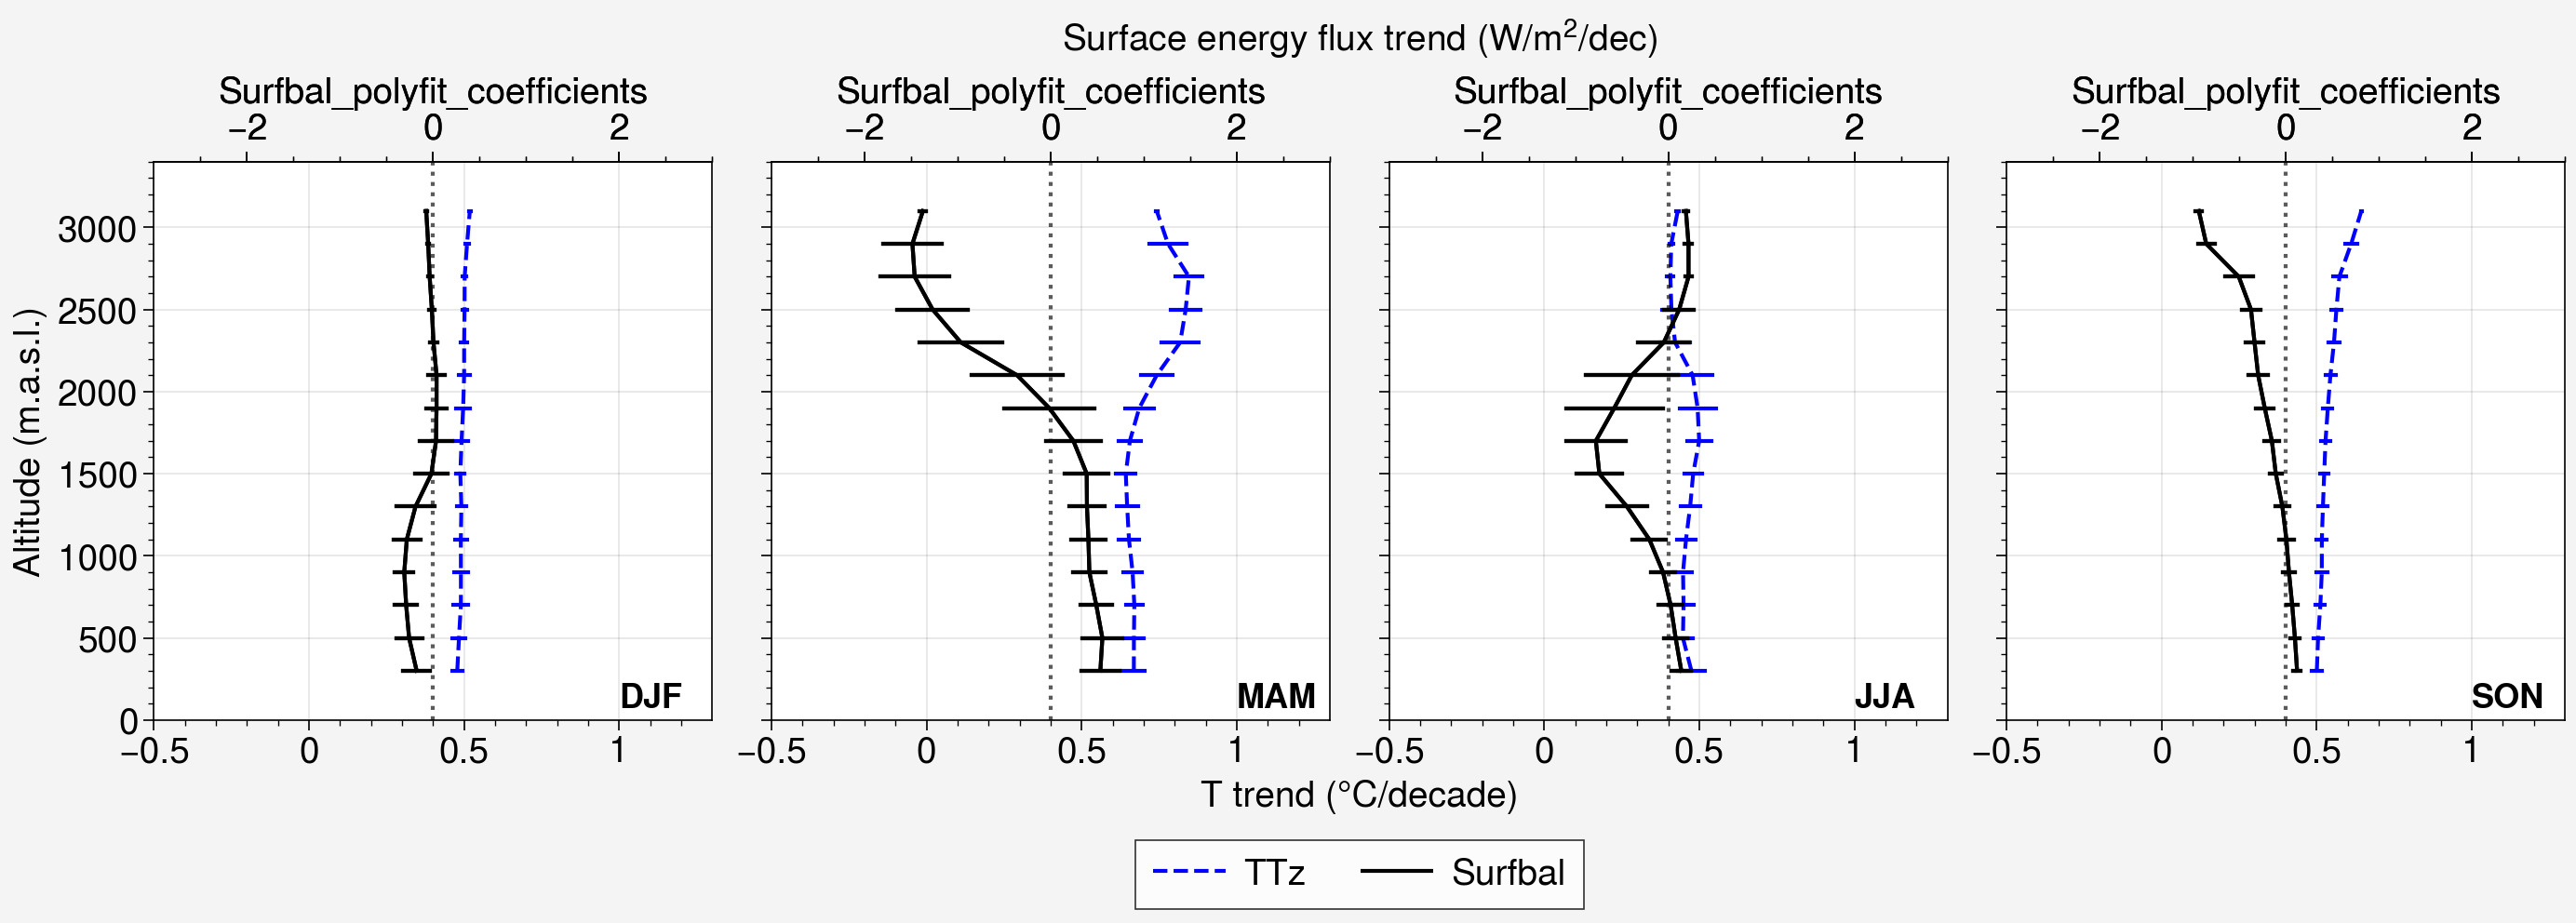

In [73]:
seasons=['DJF','MAM','JJA','SON']
colors = ['b','k']
leg_labels_null = ['','','','','','','','','','','']
leg_labels_full = ['TTz','Surfbal']
leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]

multiplier = 10 # =10 if trends per decade

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='TTz':
            ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0),H_levels,c=colors[i],linestyle='--',
                    label=leg_labels[seas][i])
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i])
        for lev in range(len(levels)): # spatial standard deviation
            if var=='TTz':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(ztqlev=0,season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i])
    ax.set_xlim(-0.5,1.3)
    ax.text(1., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-3,3)

f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/dec)'

axs.format(xlabel=xLabel,ylabel='Altitude (m.a.s.l.)',suptitle=Suptitle)

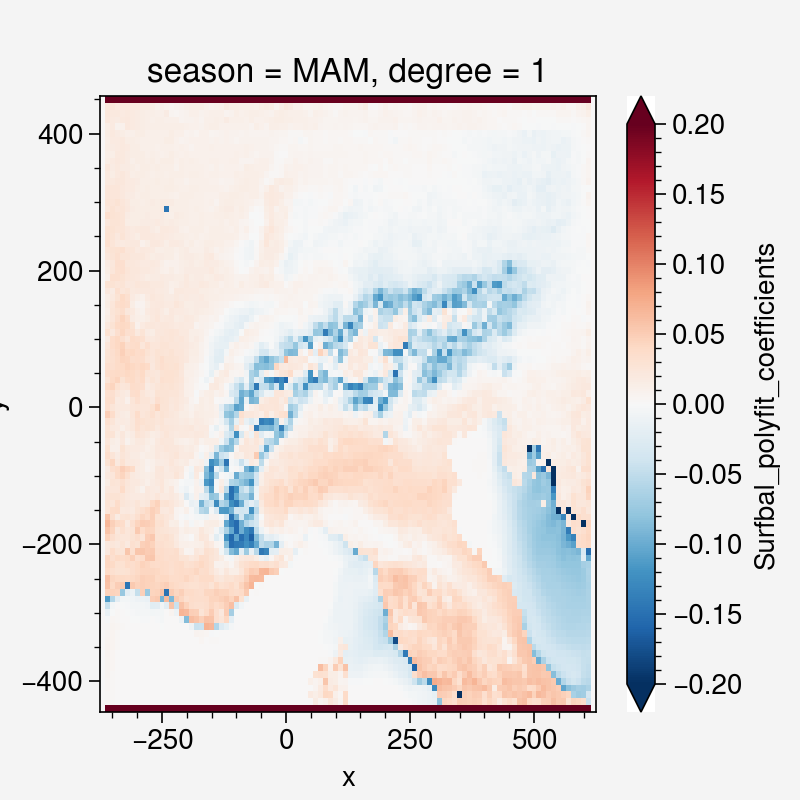

In [99]:
ds_slopes.Surfbal_polyfit_coefficients.sel(season='MAM').sel(degree=1).plot(vmin=-0.2,vmax=0.2,cmap='RdBu_r')

In [75]:
ds_slopes.Surfbal_polyfit_coefficients.sel(season='JJA').sel(degree=1)[50,50]

<xarray.DataArray 'Surfbal_polyfit_coefficients' ()>
array(-0.13055976)
Coordinates:
    season   <U3 'JJA'
    y        float32 60.0
    x        float32 130.0
    degree   int64 1

In [76]:
ds_slopes.Surfbal_polyfit_coefficients.sel(season='JJA').sel(degree=1)[35,50]

<xarray.DataArray 'Surfbal_polyfit_coefficients' ()>
array(0.08906448)
Coordinates:
    season   <U3 'JJA'
    y        float32 -90.0
    x        float32 130.0
    degree   int64 1

In [ ]:
 iloc1=50, jloc1=50, iloc2=35, jloc2=50